# Assignment 3 - Supervised Learning

## *Yifei Wang*
Netid:  *yw323*

$$\text{****** Please refer to my gitlab page for full rersolution and colorful plots ******}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import time
import collections

%config InlineBackend.figure_format = 'retina'

## 1
### [40 points] From theory to practice: classification through logistic regression

#### Introduction
For this problem you will derive, implement through gradient descent, and test the performance of a logistic regression classifier for a binary classification problem.

In this case, we'll assume our logistic regression problem will be applied to a two dimensional feature space. Our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^T \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \frac{e^x}{1-e^x}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^T \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $x_{i,0} \triangleq 1$

As in class, we will interpret the response of the logistic regression classifier to be the likelihood of the data given the model. For one sample, $(y_i, \mathbf{x_i})$, this is given as:

$$P(Y=y_i|X=x_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^T \mathbf{x}_i)$$

#### Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(a)** What is the likelihood function of the data that we will wish to maximize?

**(b)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express part (a) as a cost function of the model parameters, $C(\mathbf{w})$, that is the negative of the logarithm of (a).

**(c)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\frac{\partial C}{\partial w_0}, \frac{\partial C}{\partial w_1}, \frac{\partial C}{\partial w_2}\right]$.

**(d)** Write out the gradient descent update equation, assuming $\eta$ represents the learning rate.

#### Prepare and plot your data

**(e)** Load the data and scatter plot the data by class. In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.  Comment on the data: do the data appear separable? Why might logistic regression be a good choice for these data or not?

**(f)** Do the data require any preprocessing due to missing values, scale differences, etc? If so, how did you remediate this?

#### Implement gradient descent and your logistic regression algorithm

**(g)** Create a function or class to implement your logistic regression. It should take as inputs the model parameters, $\mathbf{w}=\left[w_0,w_1,w_2\right]$, and output the class confidence probabilities, $P(Y=y_i|X=x_i)$.

**(h)** Create a function that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels.

**(i)** Create a function or class to run gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration (or "epoch") of the algorithm. Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the test set the remaining 70 percent. In doing this we'll need to make some assumptions / experiment with the following:
1. The initialization of the algorithm - what should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
2. The learning rate - how slow/fast should the algorithm proceed in the direction opposite the gradient? This you will experiment with.
3. Stopping criteria - when should the algorithm be finished searching for the optimum? Set this to be when the cost function changes by no more than $10^{-6}$ between iterations. Since we have a weight vector, you can compute this by seeing if the L2 norm of the weight vector changes by no more than $10^{-6}$ between iterations.

**(j)** At each step in the gradient descent algorithm it will produce updated parameter estimates. For each set of estimates, calculate the cost function for both the training and the test data. 

**(k)** Show this process for different learning rates by plotting the resulting cost as a function of iteration (or "epoch"). What is the impact that each parameter has on the process and the results? What choices did you make in your chosen approach and why? Use the parameter you choose here for the learning rate for the remainder of this question.

#### Test your model performance through cross validation

**(l)** Test the performance of your trained classifier using K-folds cross validation (while this can be done manually, the scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful). Produce Receiver Operating Characteristic Curves (ROC curves) of your cross validated performance. 

**(m)** Why do we use cross validation?

**(n)** Make two plots - one of your training data, and one for your test data - with the data scatterplotted and the decision boundary for your classifier. Comment on your decision boundary. Could it be improved?

**(o)** Compare your trained model to random guessing. Show the ROC curve for your model and plot the chance diagonal. What area under the curve (AUC) does your model achieve? How does your model compare in terms of performance?

**ANSWER**

**Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.**

**(a).** Assume the binary class are 0 and 1, respectively, and $P(Y=1|X=x_i) = \sigma(\mathbf{w}^T\mathbf{x}_i)$. Therefore, we would have $$P(Y=0|X=x_i) = 1 - P(Y=1|X=x_i) = 1 - \sigma(\mathbf{w}^T\mathbf{x}_i)$$

Thus,

$$
\begin{aligned}
L(\mathbf{w}) &= P(X|\mathbf{w}) \\
     &= \prod_{i}P(Y=0|X=x_i)^{1-y_i} P(Y=1|X=x_i)^{y_i}\\
     &= \prod_{i} \left(1-\sigma(\mathbf{w}^T\mathbf{x}_i)\right)^{1-y_i} \left(\sigma(\mathbf{w}^T\mathbf{x}_i)\right)^{y_i} \\
     &= \prod_{i} \left(\frac{1}{1+e^{\mathbf{w}^T\mathbf{x}_i}}\right)^{1-y_i}\left(\frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}}\right)^{y_i}
\end{aligned}
$$

**(b).** 

$$
\begin{aligned}
C(\mathbf{w}) &= -ln(L(\mathbf{w})) \\
              &= - \sum_i \left( -(1-y_i)ln(1+e^{\mathbf{w}^T\mathbf{x}_i}) + y_iln(e^{\mathbf{w}^T\mathbf{x}_i}) - y_iln(1+e^{\mathbf{w}^T\mathbf{x}_i}) \right) \\
              &= \sum_i \left(ln(1+e^{\mathbf{w}^T\mathbf{x}_i}) - y_i {\mathbf{w}^T\mathbf{x}_i} \right)
\end{aligned}
$$

**(c).** We compute the partial derivatives respectively.

$$
\begin{aligned}
\frac{\partial C}{\partial w_0} &= \sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} x_{i,0} - \sum_{i} x_{i,0}y_i = \sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} - ||y_1|| \\ 
\frac{\partial C}{\partial w_1} &= \sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} x_{i,1} - \sum_{i} x_{i,1}y_i \\
\frac{\partial C}{\partial w_2} &= \sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} x_{i,2} - \sum_{i} x_{i,2}y_i
\end{aligned} \\
\text{where}\;\;\;||y_1||\;\text{denotes the number of observations with}\;Y = 1
$$

Therefore, the gradient of cost function is (in the notation of the question),

$$\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\begin{array}{c} \frac{\partial C}{\partial w_0} \\ \frac{\partial C}{\partial w_1} \\ \frac{\partial C}{\partial w_2}\end{array}\right]^T = \left[\begin{array}{c}
\sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} - ||y_1|| \\
\sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} x_{i,1} - \sum_{i} x_{i,1}y_i \\
\sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} x_{i,2} - \sum_{i} x_{i,2}y_i
\end{array}\right]^T$$

**(d).**

$$
\left[\begin{array}{c} w_{t+1,0}\\w_{t+1,1}\\w_{t+1,2} \end{array}\right]^T = 
\left[\begin{array}{c} w_{t,0}\\w_{t,1}\\w_{t,2} \end{array}\right]^T - \eta\,\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\begin{array}{c} w_{t,0}\\w_{t,1}\\w_{t,2} \end{array}\right]^T - \eta\,\left[\begin{array}{c} \frac{\partial C}{\partial w_0} \\ \frac{\partial C}{\partial w_1} \\ \frac{\partial C}{\partial w_2}\end{array}\right]^T = \left[\begin{array}{c} w_{t,0}\\w_{t,1}\\w_{t,2} \end{array}\right]^T - \eta\,\left[\begin{array}{c}
\sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} - ||y_1|| \\
\sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} x_{i,1} - \sum_{i} x_{i,1}y_i \\
\sum_i \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{1+e^{\mathbf{w}^T\mathbf{x}_i}} x_{i,2} - \sum_{i} x_{i,2}y_i
\end{array}\right]^T
$$

**Prepare and plot your data**

**(e).**

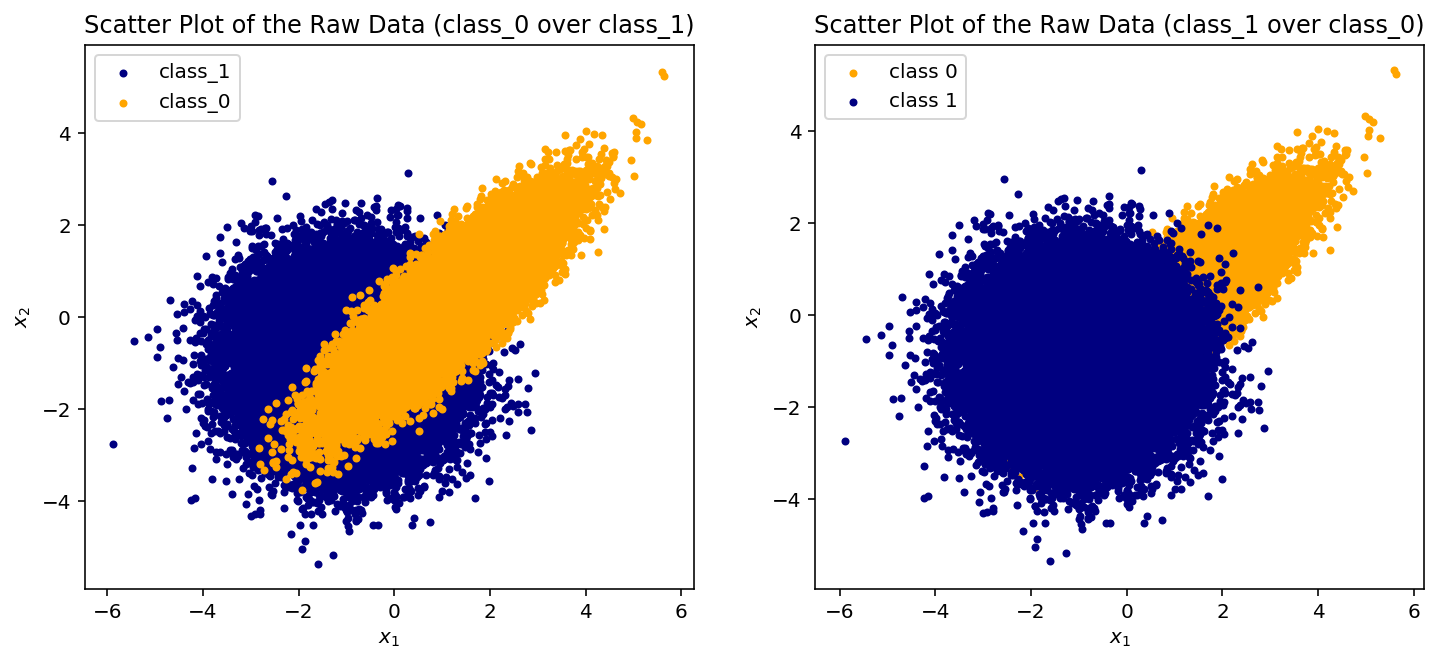

In [2]:
df1 = pd.read_csv("./data/A3_Q1_data.csv")
df1["y"] = df1["y"].astype('int').astype('category')
X_0 = df1[df1.y == 0]
X_1 = df1[df1.y == 1]

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].scatter(X_1["x1"], X_1["x2"], label = "class_1", marker = '.', c = 'navy')
axs[0].scatter(X_0["x1"], X_0["x2"], label = "class_0", marker = '.', c = 'orange')
axs[0].set_title("Scatter Plot of the Raw Data (class_0 over class_1)")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
axs[0].legend()
axs[1].scatter(X_0["x1"], X_0["x2"], label = "class 0", marker = '.', c = 'orange')
axs[1].scatter(X_1["x1"], X_1["x2"], label = "class 1", marker = '.', c = 'navy')
axs[1].set_title("Scatter Plot of the Raw Data (class_1 over class_0)")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].legend()
plt.show()

Although the plots above show that the raw data of both classes have a good shape, which could possibly be captured by logistic regression if using correct transformation, the two classes of the data have a great overlapping of each other. They appear to be not so seperable. Therefore, logistic regression might not be a good choice for this.

**(f).** The data have no null value. Also two features for these two classes are on the same scale. However, the boundary between class_0 and class_1 seems not linear, which may not perform so well if we do not do any transformation. We notice that the boundary seems to be a curve, which is part of circle. Thus, we might consider doing quadratic transformation later.

In [3]:
print("Null counts:\nx1\tx2\ty\n%d\t%d\t%d" %
      (sum(df1["x1"].isnull()),sum(df1["x2"].isnull()),sum(df1["y"].isnull())), end = '\n'+'='*40+'\n')
print("y = 0\n", X_0.describe(), end = '\n'+'='*40+'\n')
print("y = 1\n", X_1.describe())

Null counts:
x1	x2	y
0	0	0
y = 0
                  x1            x2
count  50000.000000  50000.000000
mean       1.100109      0.203307
std        1.003636      1.004628
min       -2.822922     -3.760668
25%        0.420425     -0.475846
50%        1.101855      0.203121
75%        1.779991      0.879117
max        5.634476      5.317718
y = 1
                  x1            x2
count  50000.000000  50000.000000
mean      -1.003052     -0.997519
std        1.000026      0.989751
min       -5.886436     -5.352265
25%       -1.678505     -1.663047
50%       -0.997074     -1.004444
75%       -0.325209     -0.327461
max        2.950153      3.135686


**Implement gradient descent and your logistic regression algorithm**

**(g).** Using the assumption in **(a)**, we have $P(Y=1|X=x_i) = \sigma(\mathbf{w}^T\mathbf{x}_i)$ and $P(Y=0|X=x_i) = 1 - P(Y=0|X=x_i) = 1 - \sigma(\mathbf{w}^T\mathbf{x}_i)$

In [4]:
def logistic_prob(w, x, y, test=False):
    assert len(w) == 3, "Incorrect WEIGHT lenght"
    assert len(x.shape) == 2 and len(y.shape) == 1, "Incorrect DATA shape"
    n = x.shape[0]
    X = np.c_[np.ones((n, 1)), x]
    ewx = np.exp(np.sum(w*X, axis = 1))
    ewx_ = np.exp(-np.sum(w*X, axis = 1))
    if test == False:
        return (1/(1+ewx_))**y*(1/(1+ewx))**(1-y)
    elif test == True:
        return 1/(1+ewx_)

**(h).**

In [5]:
def logistic_cost(w, x, y):
    return np.sum(-np.log(logistic_prob(w, x, y)))/x.shape[0]

**(i).**

In [6]:
n = len(df1)
all_ = np.random.choice(n, n, replace = False)
train_ = all_[:int(0.7*n)]
test_ = all_[int(0.7*n):]

df1_train = df1.loc[train_,:]
df1_test = df1.loc[test_, :]
X_train = np.array(df1_train[['x1', 'x2']])
y_train = np.array(df1_train[['y']]).flatten()
X_test = np.array(df1_test[['x1', 'x2']])
y_test = np.array(df1_test[['y']]).flatten()

In [7]:
def logistic_g(w, x, y):
    assert len(x.shape) == 2 and len(y.shape) == 1, "Incorrect DATA shape"
    X = np.c_[np.ones((x.shape[0],1)), x]
    sig_wx = 1/(1+np.exp(-np.sum(w*X, axis = 1)))
    g0 = np.sum(sig_wx) - np.sum(y)
    g1 = np.sum(sig_wx*x[:,0]) - np.sum(x[:,0]*y)
    g2 = np.sum(sig_wx*x[:,1]) - np.sum(x[:,1]*y)
    g = np.array([g0, g1, g2]) / x.shape[0]
    return g
    

def logistic_gd(x, y, xt, yt, eta, tol = 1.0e-6, seed = None):
    assert len(x.shape) == 2 and len(y.shape) == 1, "Incorrect DATA shape"
    
    # initializing
    if seed != None:
        np.random.seed(seed)
    w = np.random.random(3)
    g = logistic_g(w, x, y)
    c_train = list()
    c_test = list()
    c_train.append(logistic_cost(w,x,y))
    c_test.append(logistic_cost(w,xt,yt))
    
    # learning process
    w0 = np.linalg.norm(w)
    w = w - eta * g
    c_train.append(logistic_cost(w,x,y))
    c_test.append(logistic_cost(w,xt,yt))
    w1 = np.linalg.norm(w)
    diff = np.abs(w1 - w0)
    while diff >= tol:
        w0 = w1
        g = logistic_g(w, x, y)
        w = w - eta * g
        c_train.append(logistic_cost(w,x,y))
        c_test.append(logistic_cost(w,xt,yt))
        w1 = np.linalg.norm(w)
        diff = np.abs(w1 - w0)
    return w, c_train, c_test

**(j).**

In [8]:
def logistic_plot_cost(x, y, xt, yt, eta = [0.1], tol = 1.0e-6, end_epoch = None, seed = 323):
    '''end_epoch set the ending point for drawing cureve'''
    
    assert type(eta) == list, "format error"
    returns = list()
    plt.figure(figsize = (15, 10))
    for i in eta:
        s = time.time()
        w, c_train, c_test = logistic_gd(x, y, xt, yt, eta = i, seed = seed)
        e = time.time()
        end = None if end_epoch == None or end_epoch > len(c_train) else end_epoch
        plt.plot(c_train[:end], '-', linewidth = 5, label = 'train_%g'%i)
        plt.plot(c_test[:end], '--', linewidth = 5, label = 'test_%g'%i)
        returns.append((w,c_train, c_test, e-s))
    if end == None:
        plt.title("Standardized Cost Function Values for Training and Testing Data", fontsize=20)
    else:
        plt.title("Standardized Cost Function Values for Training and Testing Data Truncated at %d Epoch" 
                  % end_epoch, fontsize=20)
    plt.xlabel("epoch", fontsize=16)
    plt.ylabel("Standardized Cost", fontsize=16)
    plt.legend()
    plt.show()    
    return returns

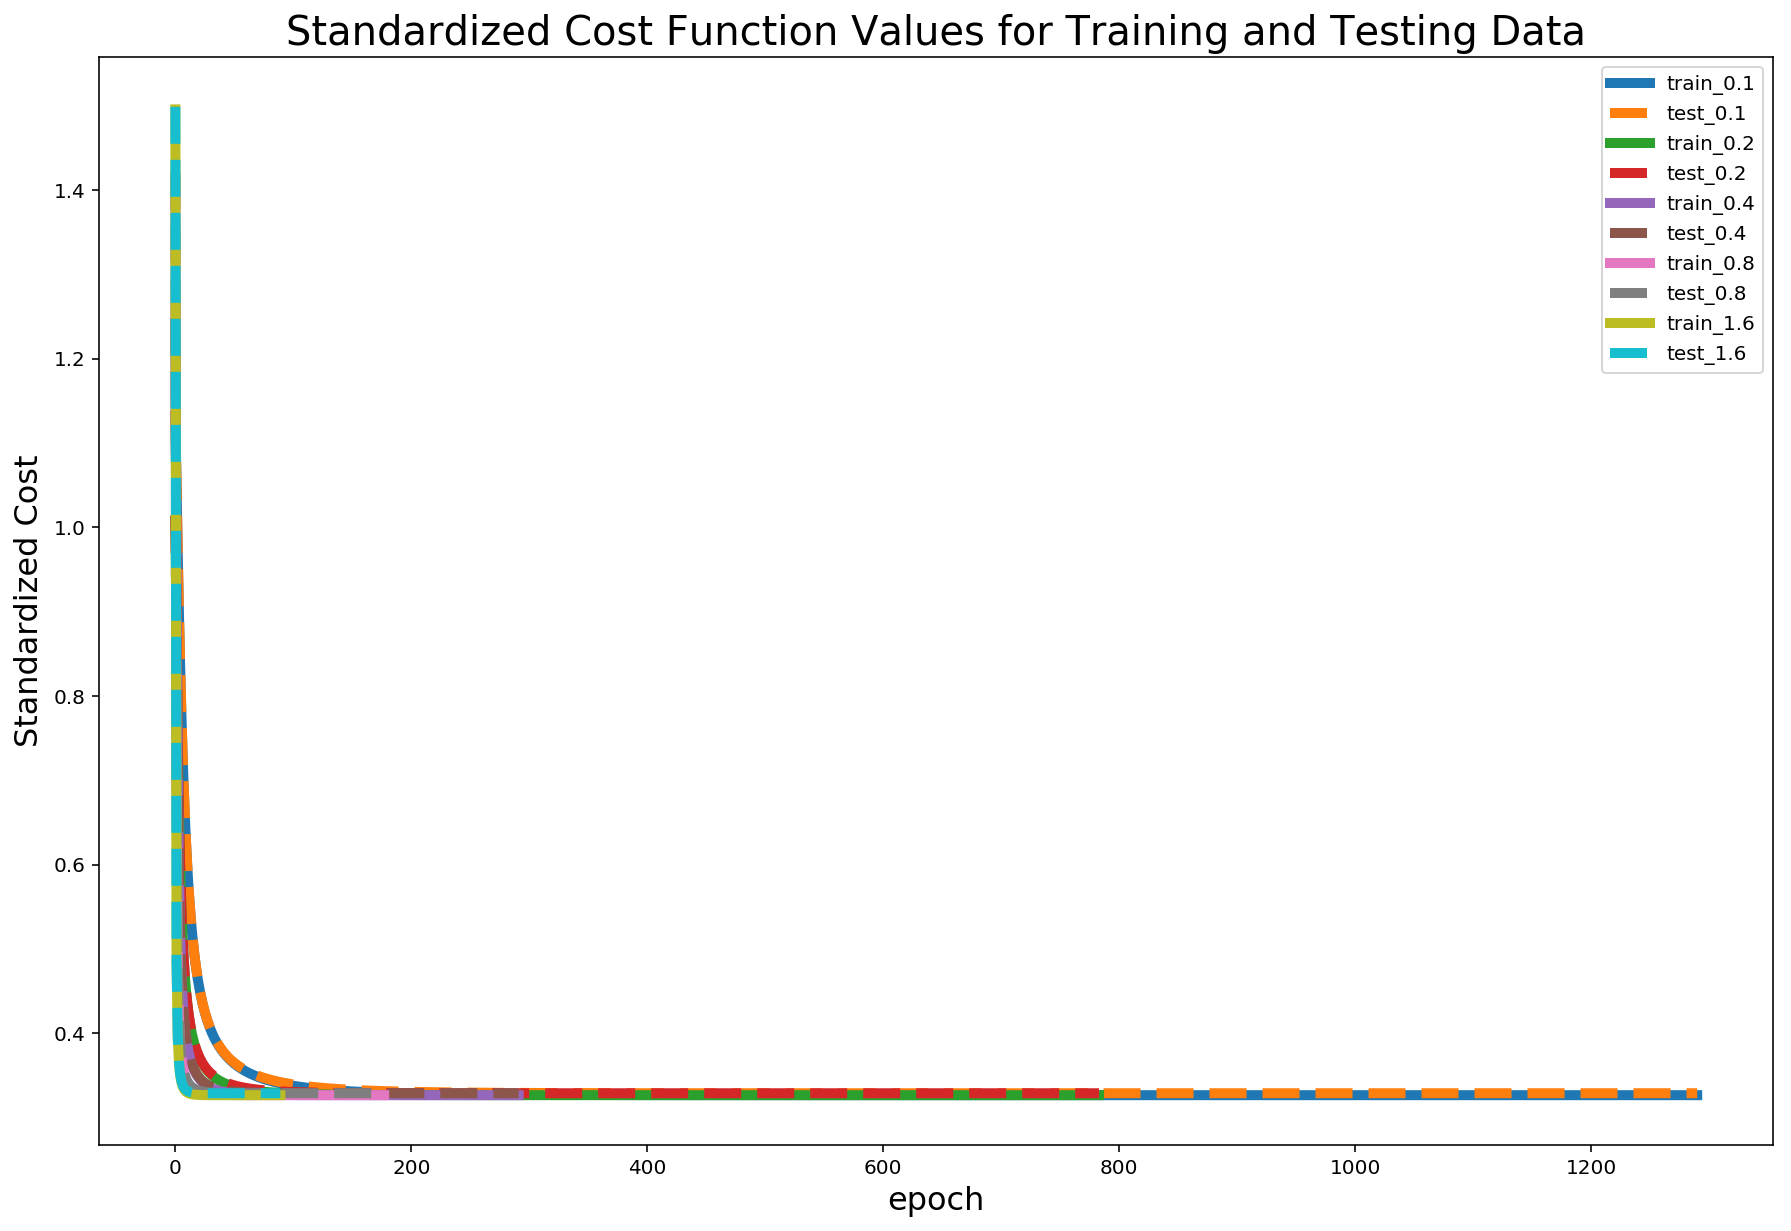

In [9]:
result1 = logistic_plot_cost(X_train, y_train, X_test, y_test, eta = [0.1, 0.2, 0.4, 0.8, 1.6], seed=None)

In [10]:
print("Training\teta = 0.1\t%f --> %f" % (result1[0][1][0], result1[0][1][-1]))
print("Testing \teta = 0.1\t%f --> %f" % (result1[0][2][0], result1[0][2][-1]))
print("Training\teta = 0.2\t%f --> %f" % (result1[1][1][0], result1[1][1][-1]))
print("Testing \teta = 0.2\t%f --> %f" % (result1[1][2][0], result1[1][2][-1]))
print("Training\teta = 0.4\t%f --> %f" % (result1[2][1][0], result1[2][1][-1]))
print("Testing \teta = 0.4\t%f --> %f" % (result1[2][2][0], result1[2][2][-1]))
print("Training\teta = 0.8\t%f --> %f" % (result1[3][1][0], result1[3][1][-1]))
print("Testing \teta = 0.8\t%f --> %f" % (result1[3][2][0], result1[3][2][-1]))
print("Training\teta = 1.6\t%f --> %f" % (result1[4][1][0], result1[4][1][-1]))
print("Testing \teta = 1.6\t%f --> %f" % (result1[4][2][0], result1[4][2][-1]))

Training	eta = 0.1	1.132791 --> 0.326704
Testing 	eta = 0.1	1.138975 --> 0.329005
Training	eta = 0.2	1.008447 --> 0.326704
Testing 	eta = 0.2	1.013644 --> 0.329004
Training	eta = 0.4	1.243951 --> 0.326704
Testing 	eta = 0.4	1.248132 --> 0.329006
Training	eta = 0.8	1.412421 --> 0.326704
Testing 	eta = 0.8	1.420434 --> 0.329005
Training	eta = 1.6	1.495789 --> 0.326704
Testing 	eta = 1.6	1.498862 --> 0.329005


By using differnt random seed, algorithm will generate differnt staring weight, with differnt cost values. However, after enough training (appropriate setting value of stopping tolerance), all of the cost values will eventually converge and stablize around a same value.

Also, for any differnt choice of learning rate, the cost function has almost the same value on both the training set and the testing set, leading to the overlapped of these two lines.

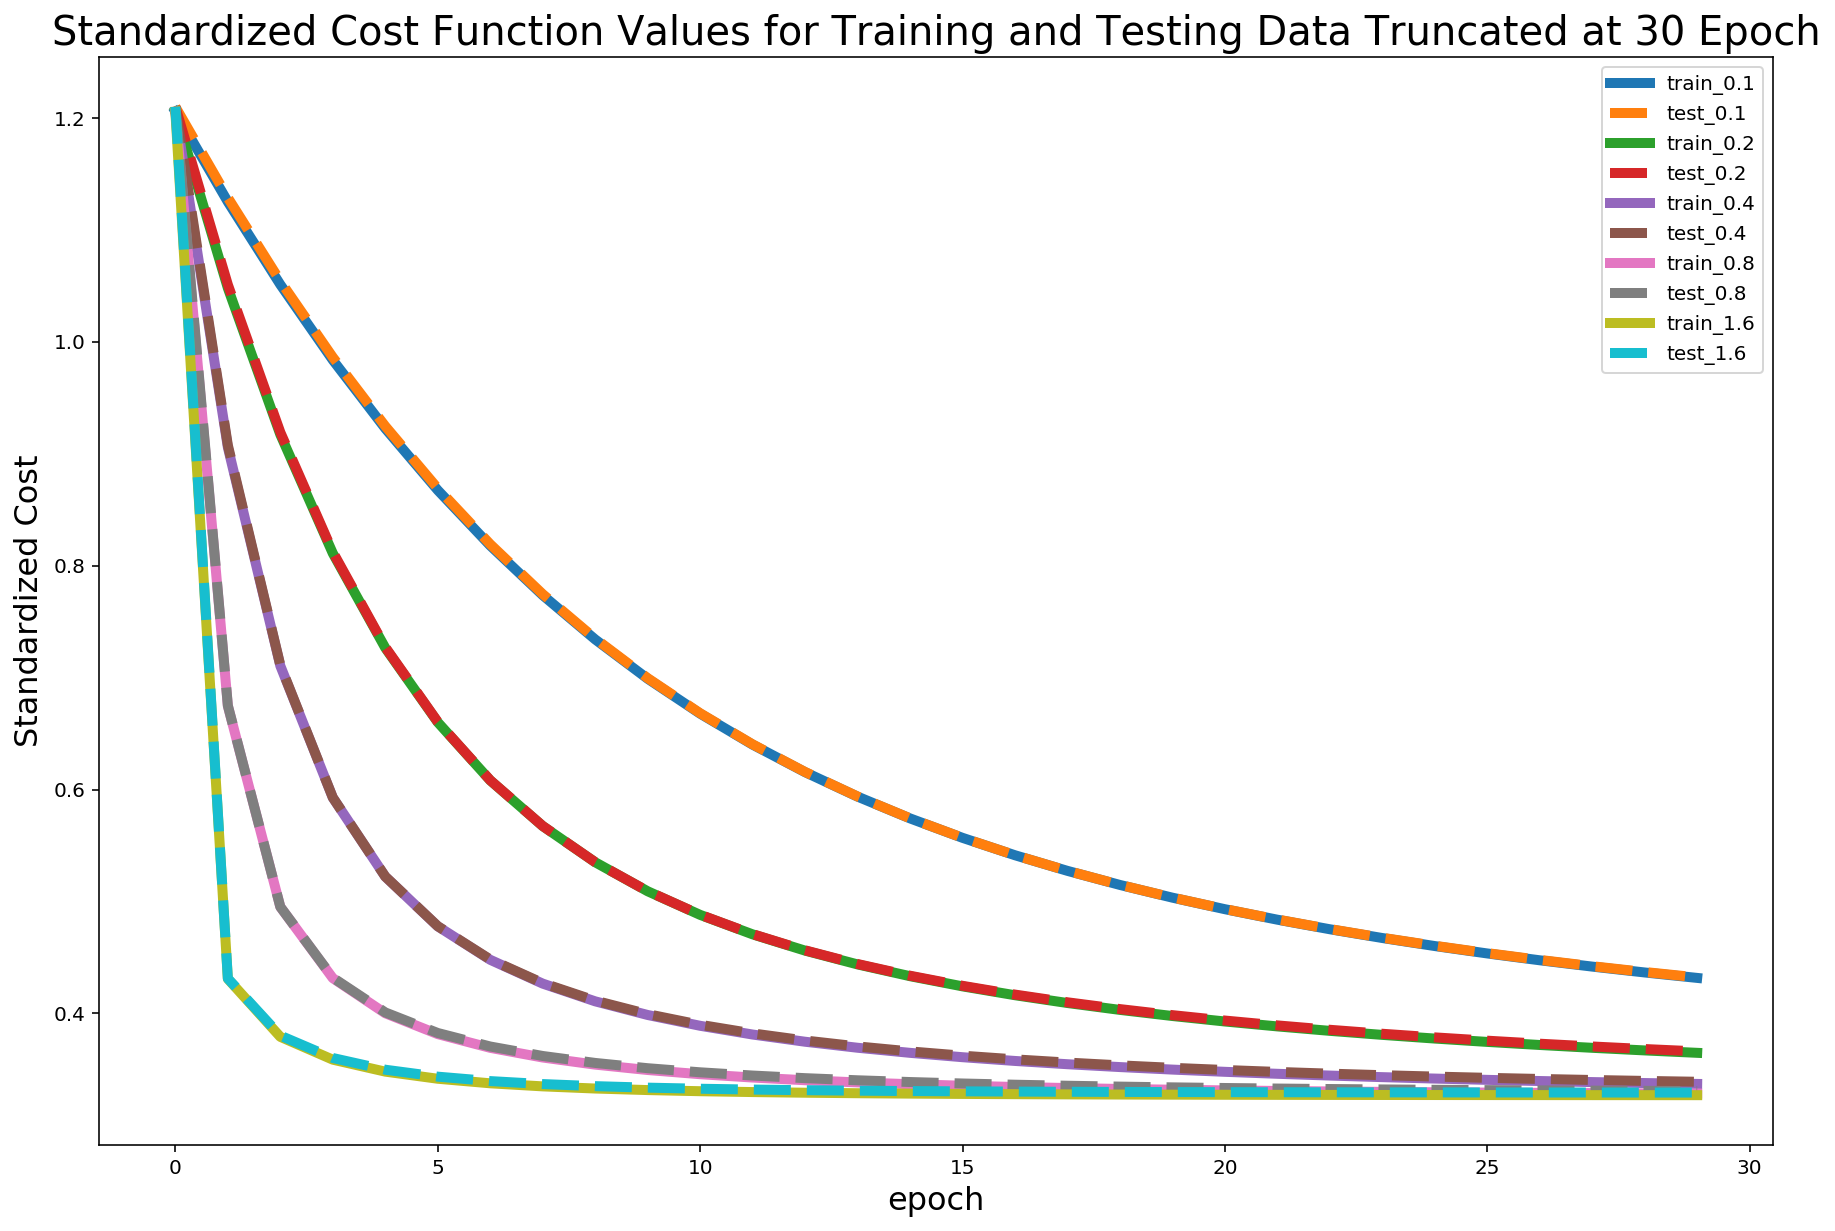

In [11]:
result2 = logistic_plot_cost(X_train, y_train, X_test, y_test, eta = [0.1, 0.2, 0.4, 0.8, 1.6], end_epoch=30)

In [12]:
print("Training\teta = 0.1\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[0][1][0],result2[0][1][-1],len(result2[0][1]),result2[0][3]))
print("Testing \teta = 0.1\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[0][2][0],result2[0][2][-1],len(result2[0][2]),result2[0][3]))
print("Training\teta = 0.2\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[1][1][0],result2[1][1][-1],len(result2[1][1]),result2[1][3]))
print("Testing \teta = 0.2\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[1][2][0],result2[1][2][-1],len(result2[1][2]),result2[1][3]))
print("Training\teta = 0.4\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[2][1][0],result2[2][1][-1],len(result2[2][1]),result2[2][3]))
print("Testing \teta = 0.4\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[2][2][0],result2[2][2][-1],len(result2[2][2]),result2[2][3]))
print("Training\teta = 0.8\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[3][1][0],result2[3][1][-1],len(result2[3][1]),result2[3][3]))
print("Testing \teta = 0.8\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[3][2][0],result2[3][2][-1],len(result2[3][2]),result2[3][3]))
print("Training\teta = 1.6\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[4][1][0],result2[4][1][-1],len(result2[4][1]),result2[4][3]))
print("Testing \teta = 1.6\t%f --> %f\tepoch = %d\ttime = %.6f s" % 
      (result2[4][2][0],result2[4][2][-1],len(result2[4][2]),result2[4][3]))

Training	eta = 0.1	1.205792 --> 0.326707	epoch = 866	time = 5.628154 s
Testing 	eta = 0.1	1.210125 --> 0.329018	epoch = 866	time = 5.628154 s
Training	eta = 0.2	1.205792 --> 0.326707	epoch = 435	time = 2.781269 s
Testing 	eta = 0.2	1.210125 --> 0.329018	epoch = 435	time = 2.781269 s
Training	eta = 0.4	1.205792 --> 0.326707	epoch = 215	time = 1.392697 s
Testing 	eta = 0.4	1.210125 --> 0.329019	epoch = 215	time = 1.392697 s
Training	eta = 0.8	1.205792 --> 0.326704	epoch = 263	time = 1.689587 s
Testing 	eta = 0.8	1.210125 --> 0.329005	epoch = 263	time = 1.689587 s
Training	eta = 1.6	1.205792 --> 0.326704	epoch = 144	time = 0.911113 s
Testing 	eta = 1.6	1.210125 --> 0.329005	epoch = 144	time = 0.911113 s


By controlling the starting weight and thus controling the starting cost value, we could see the differnt rate of convergence between differnt learning rate. Bigger learning rate will have smaller epoch counts, which means shorter time needed for convergence and more efficient algorithms. However, tradeoff existed in the choice of learning rate. Large learning rate might be faster, but also might fail to converge and fail to reach local minimums. On the other hand, small learning rate might be slower, but might be more stable to converge. 

Still, for any differnt choice of learning rate, the cost function has almost the same value on both the training set and the testing set, leading to the overlapped of these two lines.

There might be some other better choice of learning rate, but here I choose 0.4 for both an acceptable training time and a stable result.

**Test your model performance through cross validation**

**(l).**

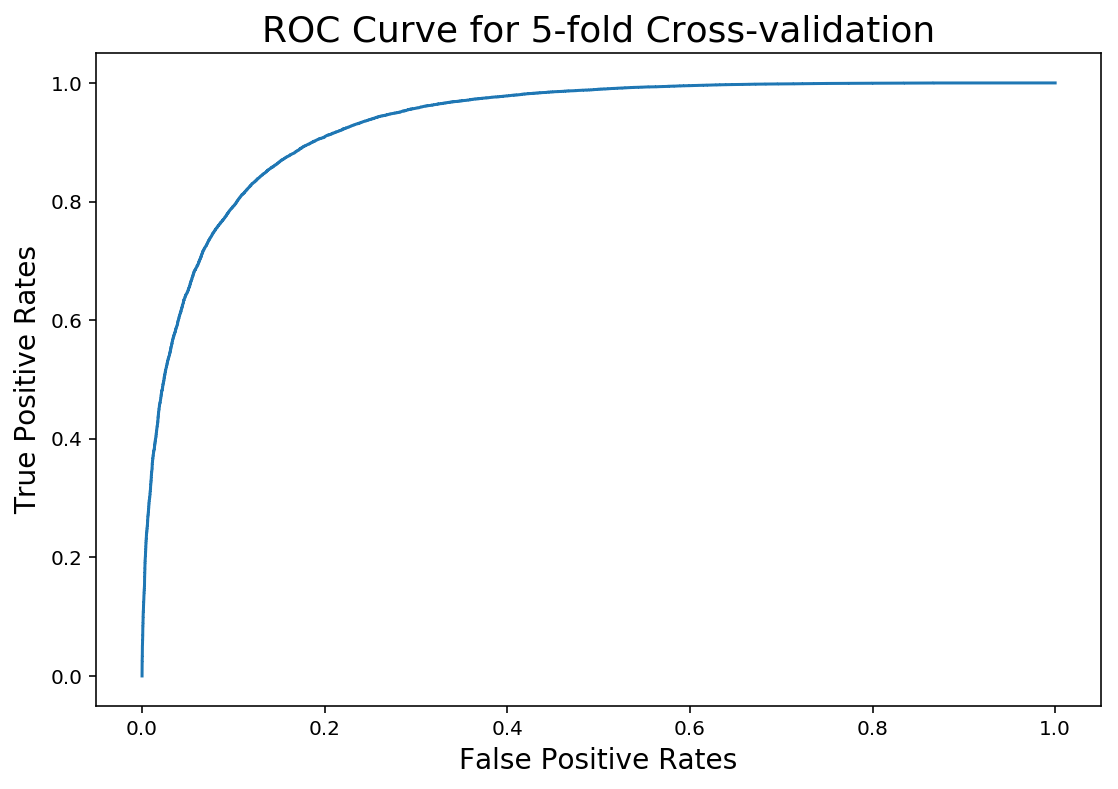

In [13]:
K = 5
skf = StratifiedKFold(n_splits=K)
#X = np.array(df1[['x1', 'x2']])
#y = np.array(df1[['y']]).flatten()

count = 0
cv_pre_prob = np.zeros(y_train.shape)
plt.figure(figsize=(9,6))
for train_i, valid_i in skf.split(X_train, y_train):
    count += 1
    train_X, valid_X = X_train[train_i], X_train[valid_i]
    train_y, valid_y = y_train[train_i], y_train[valid_i]
    
    w, c_train, c_test = logistic_gd(train_X, train_y, valid_X, valid_y, eta = 0.4, seed = None)
    y_hat = logistic_prob(w, valid_X, valid_y, test=True)
    cv_pre_prob[valid_i] = y_hat
fpr, tpr, thrshold = roc_curve(y_train, cv_pre_prob, pos_label=1)
plt.plot(fpr, tpr)
plt.title("ROC Curve for %d-fold Cross-validation" % K, fontsize=18)
plt.ylabel("True Positive Rates", fontsize=14)
plt.xlabel("False Positive Rates", fontsize=14)
plt.show()

**(m).** The ultimate goal for our machine learning process is to perform well on the data we haven't seen (testing), but not on the data we have already seen (training). Given a bunch of data, it is necessary for us to seperate them into training and testing data. We train our model only on training data and test its performance on testing data. Also, for both of the training and testing process, we want as large as possible amount of data to reach a stable training error and testing error. However, "leave-one-out" is not that efficient while "half-half" might provide not enough data for training. Thus we use cross validation to reach a balance between computation expenses and training/testing stability. 

**(n).**

In [14]:
grid = np.arange(-6,6.01,0.01)
XX, YY = np.meshgrid(grid, grid)
#print(np.mgrid[-6:6:0.01, -6:6:0.01])
x1 = XX.flatten()
x2 = YY.flatten()
X_test_grid = np.c_[x1,x2]
y = np.zeros_like(x2)

w, c_train, c_test = logistic_gd(X_train, y_train, X_test, y_test, eta=0.4)
y_hat = logistic_prob(w, X_test_grid, y, test=True).reshape(XX.shape)

In [15]:
X_train_1 = np.array(df1_train[df1_train.y == 1][['x1', 'x2']])
X_train_0 = np.array(df1_train[df1_train.y == 0][['x1', 'x2']])
X_test_1 = np.array(df1_test[df1_test.y == 1][['x1', 'x2']])
X_test_0 = np.array(df1_test[df1_test.y == 0][['x1', 'x2']])

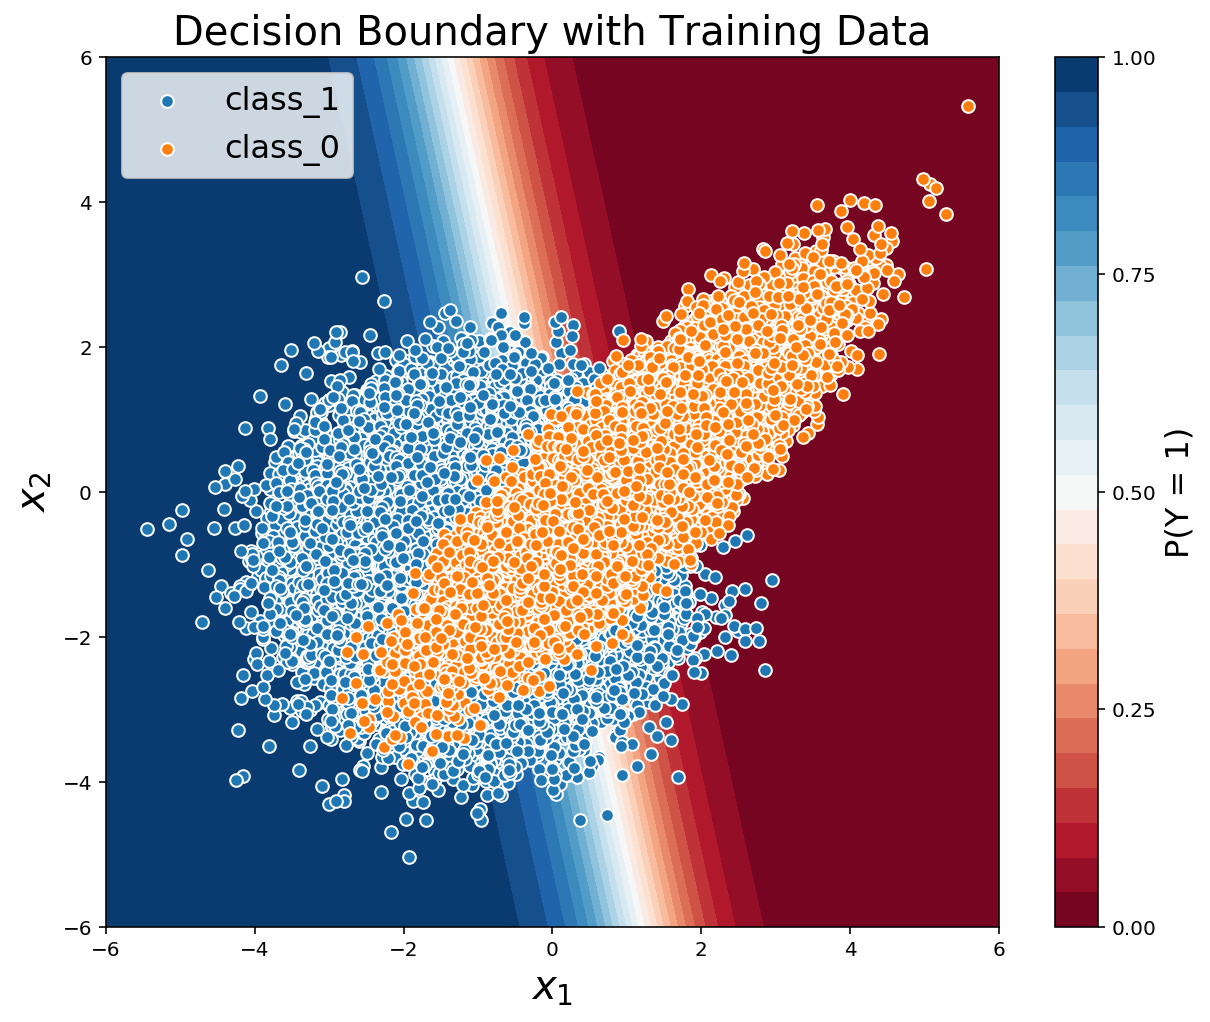

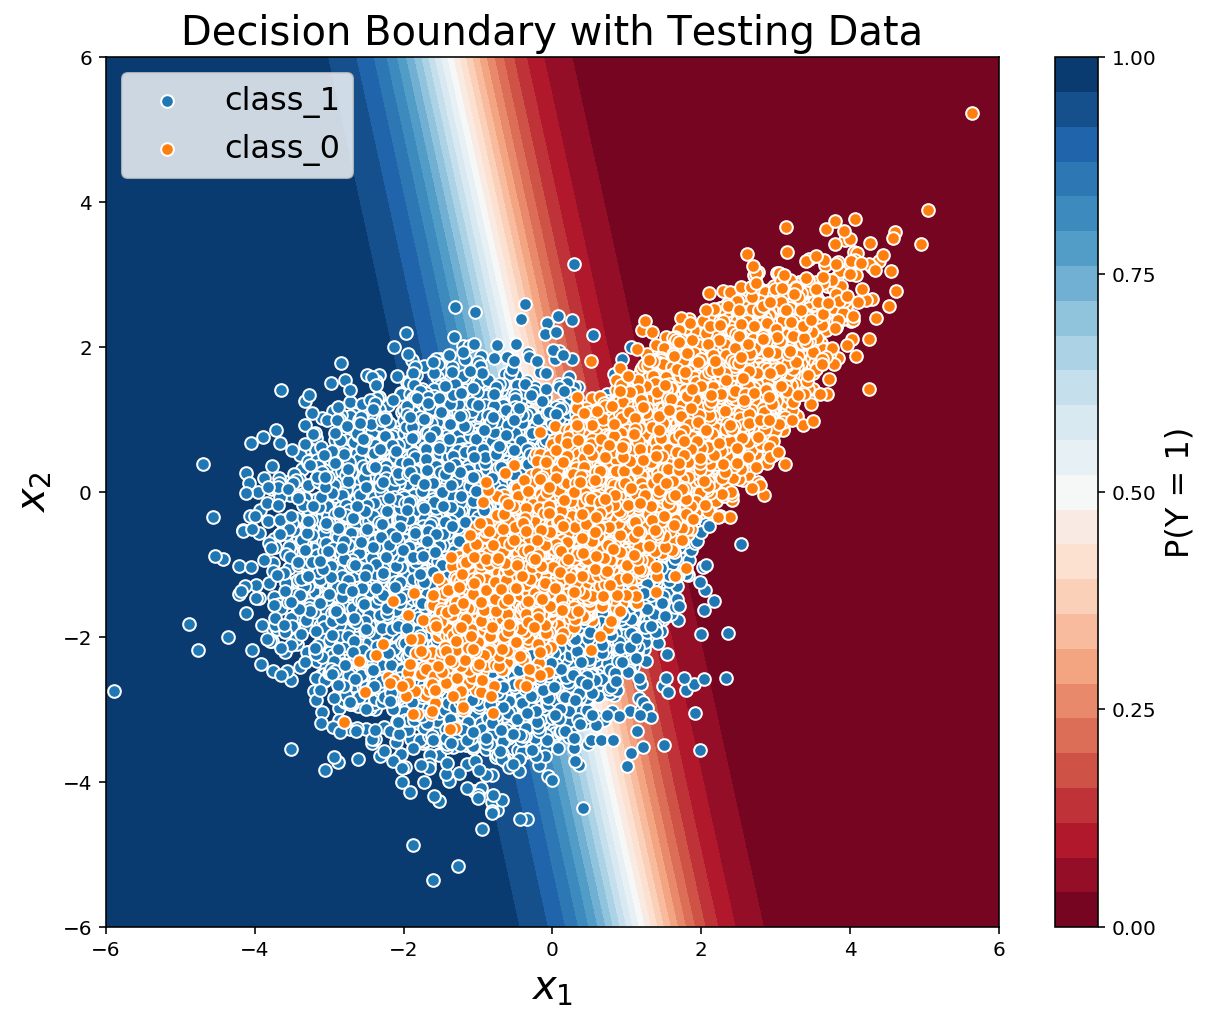

In [16]:
plt.figure(figsize=(10,8))
con = plt.contourf(XX, YY, y_hat, 25, cmap="RdBu", vmin=0, vmax=1)
cbar = plt.colorbar(con)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
cbar.set_label("P(Y = 1)", fontsize=16)
plt.title("Decision Boundary with Training Data", fontsize=20)
plt.xlabel("$x_1$", fontsize=20)
plt.ylabel("$x_2$", fontsize=20)
plt.scatter(X_train_1[:,0], X_train_1[:,1], s=40, cmap="RdBu", label="class_1",
            edgecolor="white", linewidth=1)
plt.scatter(X_train_0[:,0], X_train_0[:,1], s=40, cmap="RdBu", label="class_0",
            edgecolor="white", linewidth=1)
plt.legend(loc=2, prop={'size':16})
plt.show()

plt.figure(figsize=(10,8))
con = plt.contourf(XX, YY, y_hat, 25, cmap="RdBu", vmin=0, vmax=1)
cbar = plt.colorbar(con)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
cbar.set_label("P(Y = 1)", fontsize=16)
plt.title("Decision Boundary with Testing Data", fontsize=20)
plt.xlabel("$x_1$", fontsize=20)
plt.ylabel("$x_2$", fontsize=20)
plt.scatter(X_test_1[:,0], X_test_1[:,1], s=40, cmap="RdBu", label="class_1",
            edgecolor="white", linewidth=1)
plt.scatter(X_test_0[:,0], X_test_0[:,1], s=40, cmap="RdBu", label="class_0",
            edgecolor="white", linewidth=1)
plt.legend(loc=2, prop={'size':16})
plt.show()

This decision boundary could be improved, because here the boundary is simply a straight line. However, we can tell from the plot that these two classes seem could be better seperated by a curve. This require the transformation of $x_1$ and $x_2$.

**(o).** 

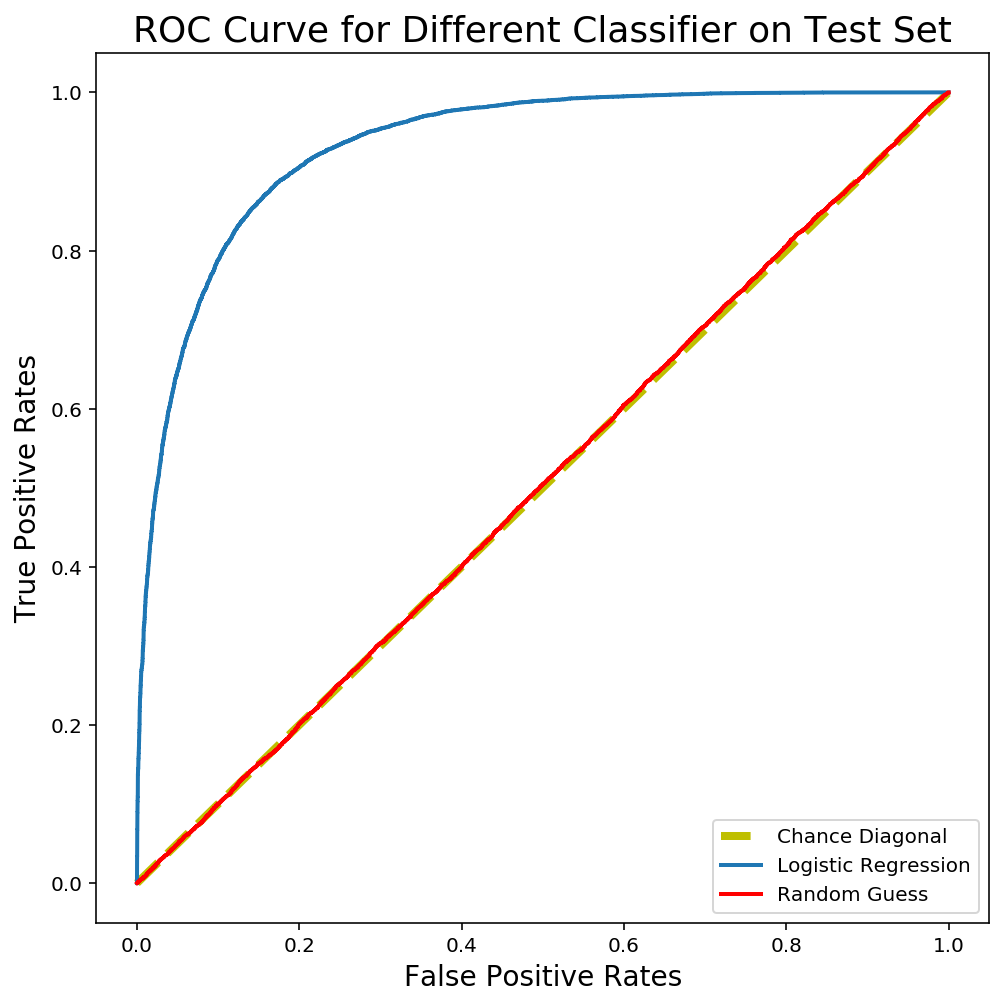

			AUC of ROC
Logistic Regression	0.933
Random Guess		0.502


In [17]:
y_hat = logistic_prob(w, X_test, np.array([0]), test=True)
y_rd = np.random.random(y_hat.shape)

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'y--', label="Chance Diagonal", linewidth=4)
fpr, tpr, thrshold = roc_curve(y_test, y_hat, pos_label=1)
plt.plot(fpr, tpr, label="Logistic Regression", linewidth=2)
fpr, tpr, thrshold = roc_curve(y_test, y_rd, pos_label=1)
plt.plot(fpr, tpr, 'r', label="Random Guess", linewidth=2)

plt.title("ROC Curve for Different Classifier on Test Set", fontsize=18)
plt.ylabel("True Positive Rates", fontsize=14)
plt.xlabel("False Positive Rates", fontsize=14)
plt.legend()
plt.show()

print("\t\t\tAUC of ROC")
print("Logistic Regression\t%.3f" % roc_auc_score(y_test, y_hat))
print("Random Guess\t\t%.3f" % roc_auc_score(y_test, y_rd))

In [18]:
# confusion matrix
y_pre = np.where(y_hat > 0.5, 1, 0)
y_rd_pre = np.where(y_rd > 0.5, 1, 0)
cm1 = confusion_matrix(y_test, y_pre)
cm2 = confusion_matrix(y_test, y_rd_pre)
print("Confusion Matrix")
print("="*20)
print("Logistic Regression")
print("\tNeg\tPos")
print("-\t%d\t%d" % (cm1[0,0], cm1[0,1]))
print("+\t%d\t%d" % (cm1[1,0], cm1[1,1]))
print("="*20)
print("Random Guess")
print("\tNeg\tPos")
print("-\t%d\t%d" % (cm2[0,0], cm2[0,1]))
print("+\t%d\t%d" % (cm2[1,0], cm2[1,1]))
print("="*20)

Confusion Matrix
Logistic Regression
	Neg	Pos
-	12666	2293
+	2026	13015
Random Guess
	Neg	Pos
-	7586	7373
+	7565	7476


We can see that in general the logistic regression out-performed random guess classifier. Logistic regression has a greater Area Under Curve score for its ROC curve than Random Guess. Logistic regression also has a higher precision, recall and overall accuracy shown by the confusion matrix.

## 2

### [20 points] Digits classification

**(a)** Construct your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, which has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to determine whether or not an example is a 3, therefore your binary classifier will seek to estimate $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format. 

**(b)** Plot 10 examples of each class 0 and 1, from the training dataset.

**(c)** How many examples are present in each class? Are the classes balanced? What issues might this cause?

**(d)** Using cross-validation, train and test a classifier. Compare your performance against (1) a classifier that randomly guesses the class, and (2) a classifier that guesses that all examples are NOT 3's. Plot corresponding ROC curves and precision-recall curves. Describe the algorithm's performance and explain any discrepancies you find.

**(f)** Using a logistic regression classifier (a linear classifier), apply lasso regularization and retrain the model and evaluate its performance over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module (DO NOT use your function from question 1) and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. As you vary the regularization coefficient, plot (1) the number of model parameters that are estimated to be nonzero; (2) the logistic regression cost function, which you created a function to evaluate in the Question 1; (3) $F_1$-score, and (4) area under the curve (AUC). Describe the implications of your findings.

**ANSWER**

**(a)**

In [19]:
def read_mnist(file, skip):
    f = np.fromfile(file, dtype = 'ubyte')
    t = f[:skip]
    print('-'*10)
    
    # print the magic number
    for i in range(skip//4):
        print(t[i*4+0]*2*16+t[i*4+1]*2**12+t[i*4+2]*2**8+t[i*4+3])
    return f[skip:]

train_image = read_mnist("./data/A3_train-images-idx3-ubyte", skip = 16).reshape(60000, 784)
train_label_raw = read_mnist("./data/A3_train-labels-idx1-ubyte", skip = 8)
test_image = read_mnist("./data/A3_t10k-images-idx3-ubyte", skip = 16).reshape(10000, 784)
test_label_raw = read_mnist("./data/A3_t10k-labels-idx1-ubyte", skip = 8); print('-'*10)

----------
2051
60000
28
28
----------
2049
60000
----------
2051
10000
28
28
----------
2049
10000
----------


In [20]:
def convert_label(raw, i):
    returns = np.zeros_like(raw)
    returns[(raw - i*np.ones_like(raw))==0] =+ 1
    return returns

train_label = convert_label(train_label_raw, 3)
test_label = convert_label(test_label_raw, 3)

**(b)**

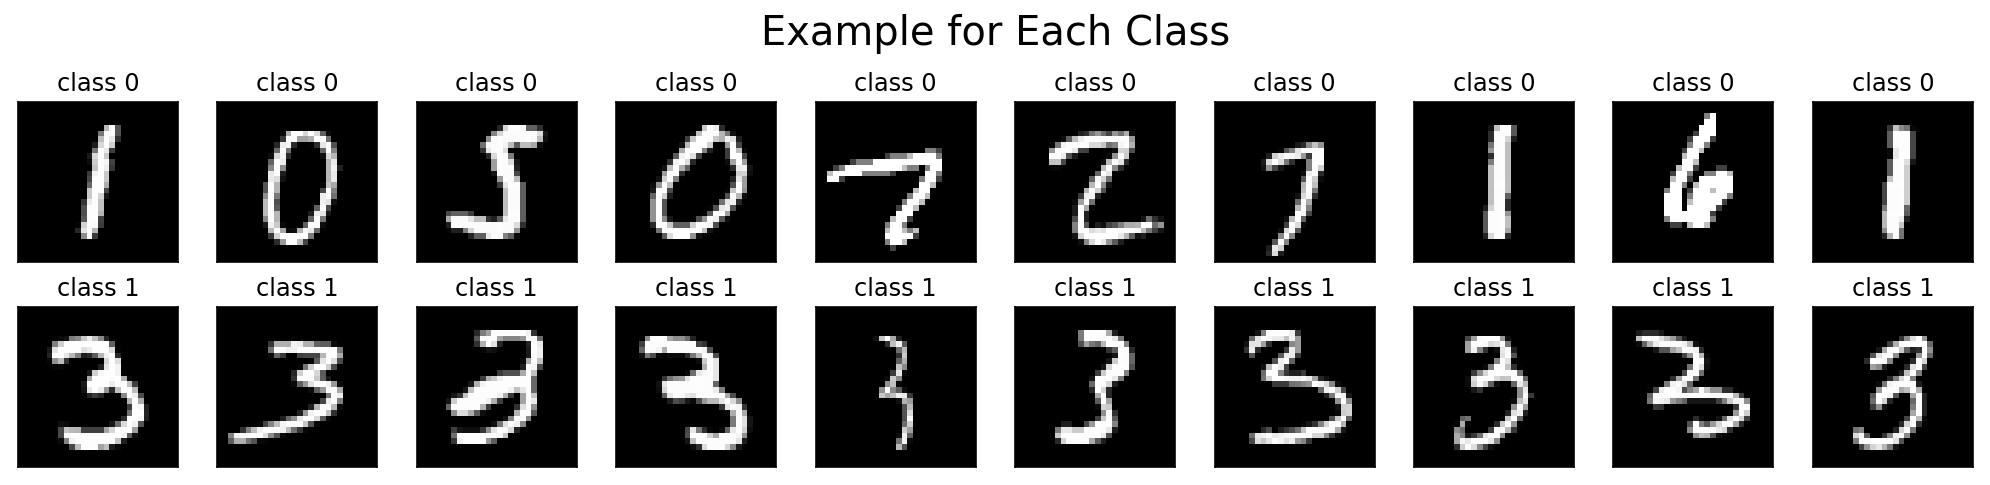

In [21]:
fig, axs = plt.subplots(2,10, figsize=(14,3))
for i, axr in enumerate(axs):
    for ax in axr:
        r = np.random.randint(0,60000)
        while train_label[r] != i:
            r = np.random.randint(0,60000)
        ax.set_title("class %d"%i)
        ax.imshow(train_image[r].reshape(28,28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle("Example for Each Class", fontsize=20, y = 1.1)
plt.tight_layout()
plt.show()

**(c)**

In [22]:
label_raw_count = collections.Counter(train_label_raw)
label_raw_count

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

In [23]:
label_count = collections.Counter(train_label)
label_count

Counter({0: 53869, 1: 6131})

The counts for both original labels and our self-assigned labels are shown above. We could see that the distribution of original labels is quite balanced, but the distribuiton of self-assigned one is unbalanced. This might cause problem when evaluating the results of our classification models. Even a trivial model that predicting each observation to be negative could reach a accuracy around 89.78%. Thus, when evaluating our models, we should not only focus on accuracy but also look at other statistics such as recall, true negative rate, precision, etc., using ROC curve or confusion matrix.

**(d)**

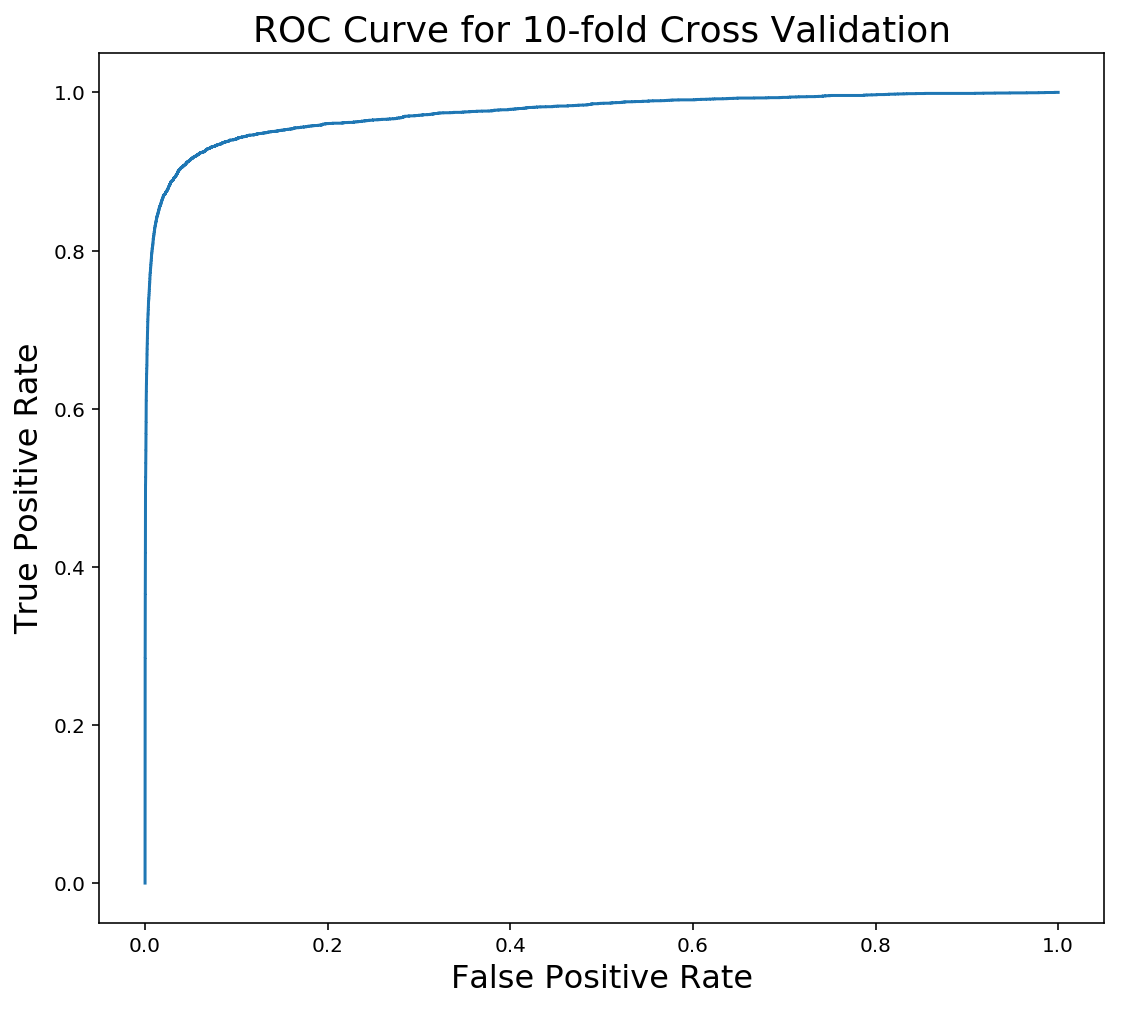

In [24]:
# Using k-fold cross-validation to train and test on training data
import warnings

K = 10
plt.figure(figsize=(9,8))
cv_pre_proba = np.zeros(train_label.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = StratifiedKFold(n_splits=K)
    for train_i, valid_i in kfold.split(train_image, train_label):
        train_X, valid_X = train_image[train_i], train_image[valid_i]
        train_y, valid_y = train_label[train_i], train_label[valid_i]

        logit = LogisticRegression(random_state=323, solver='lbfgs', max_iter=100).fit(train_X, train_y)
        y_prob = logit.predict_proba(valid_X)[:,1]
        cv_pre_proba[valid_i] = y_prob
fpr, tpr, thrshold = roc_curve(train_label, cv_pre_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.title("ROC Curve for %d-fold Cross Validation"%K, fontsize=18)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.show()

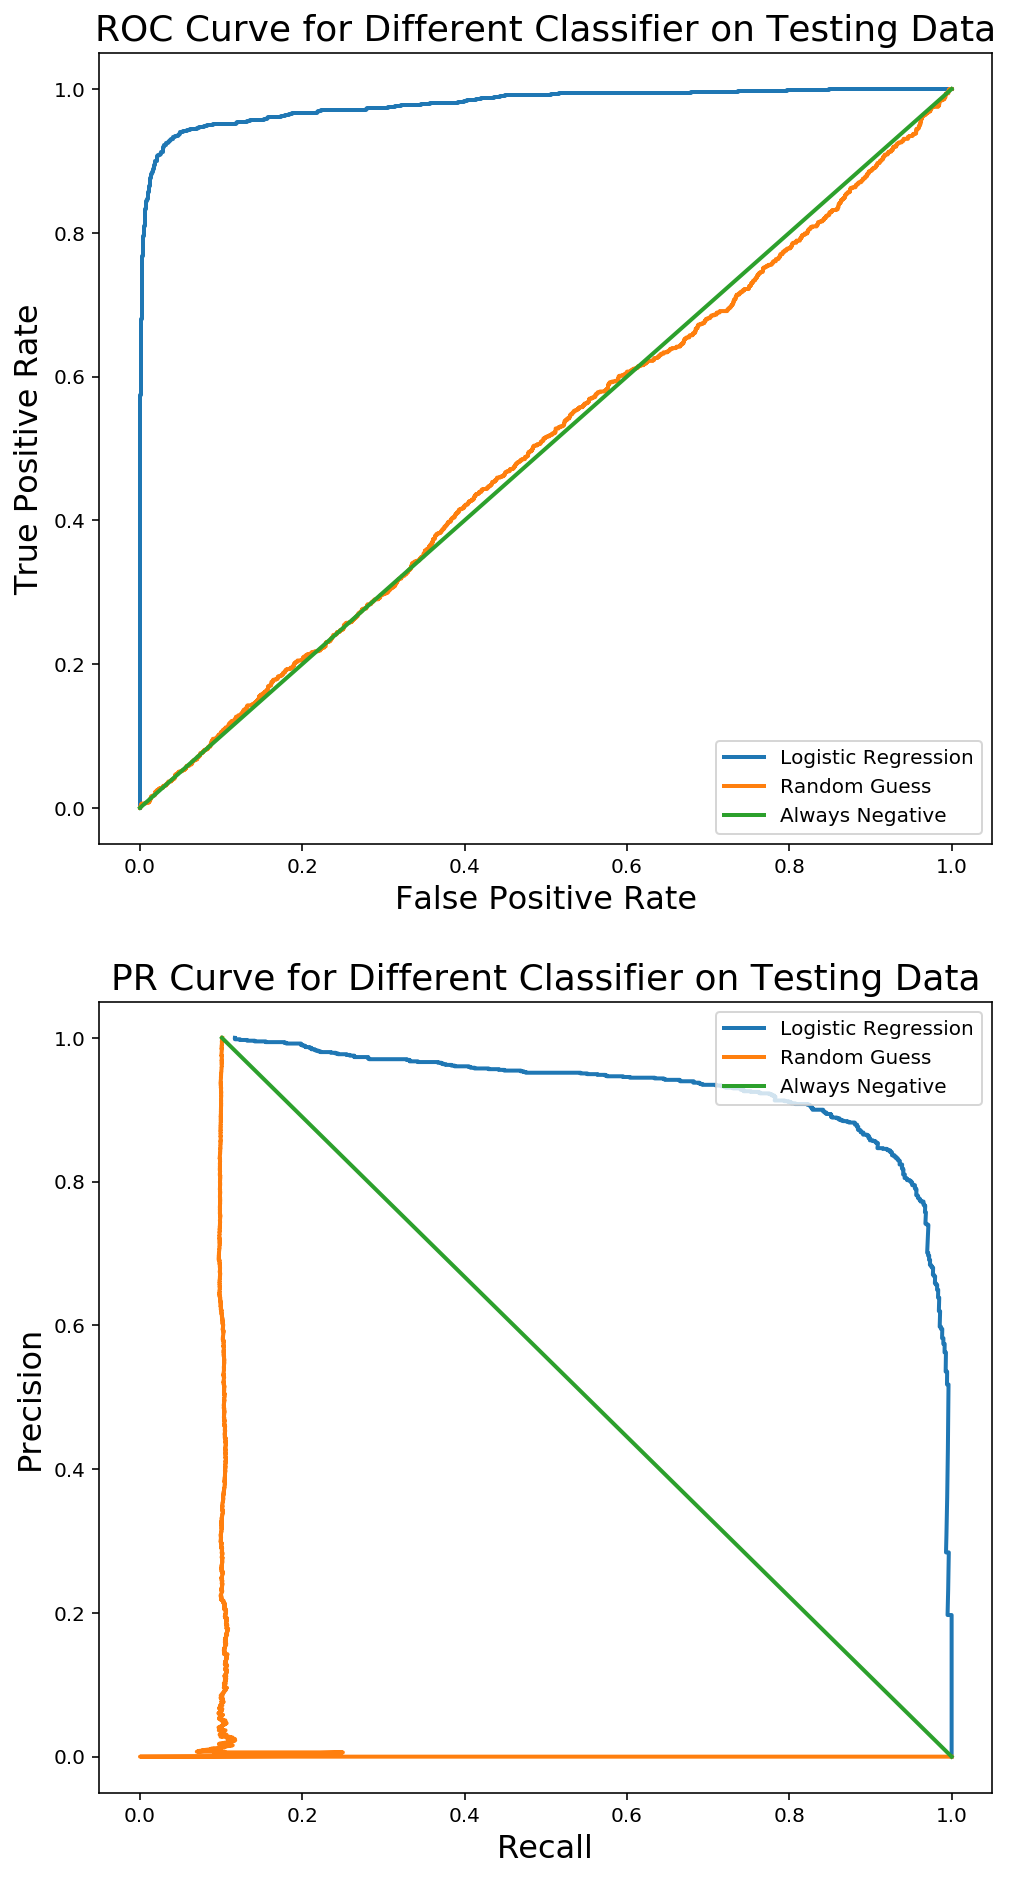

In [25]:
# run model on the whole training data and test on testing data

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    logit = LogisticRegression(random_state=323, solver='lbfgs', max_iter=100).fit(train_image, train_label)
    
fig, axs = plt.subplots(2, 1, figsize=(8,16))
y_prob = logit.predict_proba(test_image)[:,1]
y_random = np.random.random(10000)
y_neg = np.zeros(10000)
# plot ROC curve
fpr, tpr, thrshold = roc_curve(test_label, y_prob, pos_label=1)
axs[0].plot(fpr, tpr, label="Logistic Regression", linewidth=2)
fpr, tpr, thrshold = roc_curve(test_label, y_random, pos_label=1)
axs[0].plot(fpr, tpr, label="Random Guess", linewidth=2)
fpr, tpr, thrshold = roc_curve(test_label, y_neg, pos_label=1)
axs[0].plot(fpr, tpr, label="Always Negative", linewidth=2)
axs[0].set_title("ROC Curve for Different Classifier on Testing Data", fontsize=18)
axs[0].set_xlabel("False Positive Rate", fontsize=16)
axs[0].set_ylabel("True Positive Rate", fontsize=16)
axs[0].legend()
# plot PR curve
pr, re, thrshold = precision_recall_curve(test_label, y_prob, pos_label=1)
axs[1].plot(pr, re, label="Logistic Regression", linewidth=2)
pr, re, thrshold = precision_recall_curve(test_label, y_random, pos_label=1)
axs[1].plot(pr, re, label="Random Guess", linewidth=2)
pr, re, thrshold = precision_recall_curve(test_label, y_neg, pos_label=1)
axs[1].plot(pr, re, label="Always Negative", linewidth=2)
axs[1].set_title("PR Curve for Different Classifier on Testing Data", fontsize=18)
axs[1].set_xlabel("Recall", fontsize=16)
axs[1].set_ylabel("Precision", fontsize=16)
axs[1].legend(loc=1)
plt.show()

In [26]:
# confusion matrix

y_hat = logit.predict(test_image)
y_random = np.random.randint(0,2,10000)
y_neg = np.zeros(10000)
cm1 = confusion_matrix(test_label, y_hat)
cm2 = confusion_matrix(test_label, y_random)
cm3 = confusion_matrix(test_label, y_neg)
print("Confusion Matrix")
print("="*20)
print("Logistic Regression")
print("\tNeg\tPos")
print("-\t%d\t%d" % (cm1[0,0], cm1[0,1]))
print("+\t%d\t%d" % (cm1[1,0], cm1[1,1]))
print("="*20)
print("Random Guess")
print("\tNeg\tPos")
print("-\t%d\t%d" % (cm2[0,0], cm2[0,1]))
print("+\t%d\t%d" % (cm2[1,0], cm2[1,1]))
print("="*20)
print("Always Neg")
print("\tNeg\tPos")
print("-\t%d\t%d" % (cm3[0,0], cm3[0,1]))
print("+\t%d\t%d" % (cm3[1,0], cm3[1,1]))
print("="*20)

Confusion Matrix
Logistic Regression
	Neg	Pos
-	8888	102
+	137	873
Random Guess
	Neg	Pos
-	4570	4420
+	532	478
Always Neg
	Neg	Pos
-	8990	0
+	1010	0


Comparing the differences between these 3 classifiers, we could see that logistic regression outperforms both of the others in overall senses. 

For the overall accuracy, logistic regression reach 97.65% while "Random Guess" is around 50% and "Always Neg" is around 90%.

For the recall, logistic regression reach around 99% while "Random Guess" is around 50% and "Always Neg" is 100%.

For the false negative rate, logistic regression is 10.1% while "Random Guess" is around 52% and "Always Neg" is 100%.

For the precision, logistic regression is around 98% while "Random Guess" is around 90% and "Always Neg" is around 90%.

Logistic regression could outperform "Random Guess" in every aspects. It could also be better than "Always Neg" except for recall. However, the reason for a high recall of "Always Nec" is its no prediction outcome of positive at all, which is not practical. 

**(f)**

In [27]:
def logit_lasso(C, test, label):
    # assume C is decreasing
    coef_count = list()
    cost = list()
    f1_binary = list()
    auc = list()
    cnt = 0
    for c in C:
        cnt += 1
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            logit_lasso_c = LogisticRegression(penalty='l1', random_state=323, 
                                     C = c).fit(train_image, train_label)
        pre_label = logit_lasso_c.predict(test)
        pre_proba = logit_lasso_c.predict_proba(test)
        coef_count.append(np.sum(np.isclose(logit_lasso_c.coef_, 0)))
        cost.append(-np.sum(np.log(pre_proba**np.c_[1-label, label]))/label.shape)
        f1_binary.append(f1_score(label, pre_label, pos_label=1))
        auc.append(roc_auc_score(label, pre_proba[:,1]))
        print("=",end="") if cnt%5!=0 else print(cnt,end="")
    return 28*28-np.array(coef_count), cost, f1_binary, auc

In [28]:
C = np.logspace(3,-5,25)
result_stats = logit_lasso(C, test_image, test_label)

====5====10====15====20====25

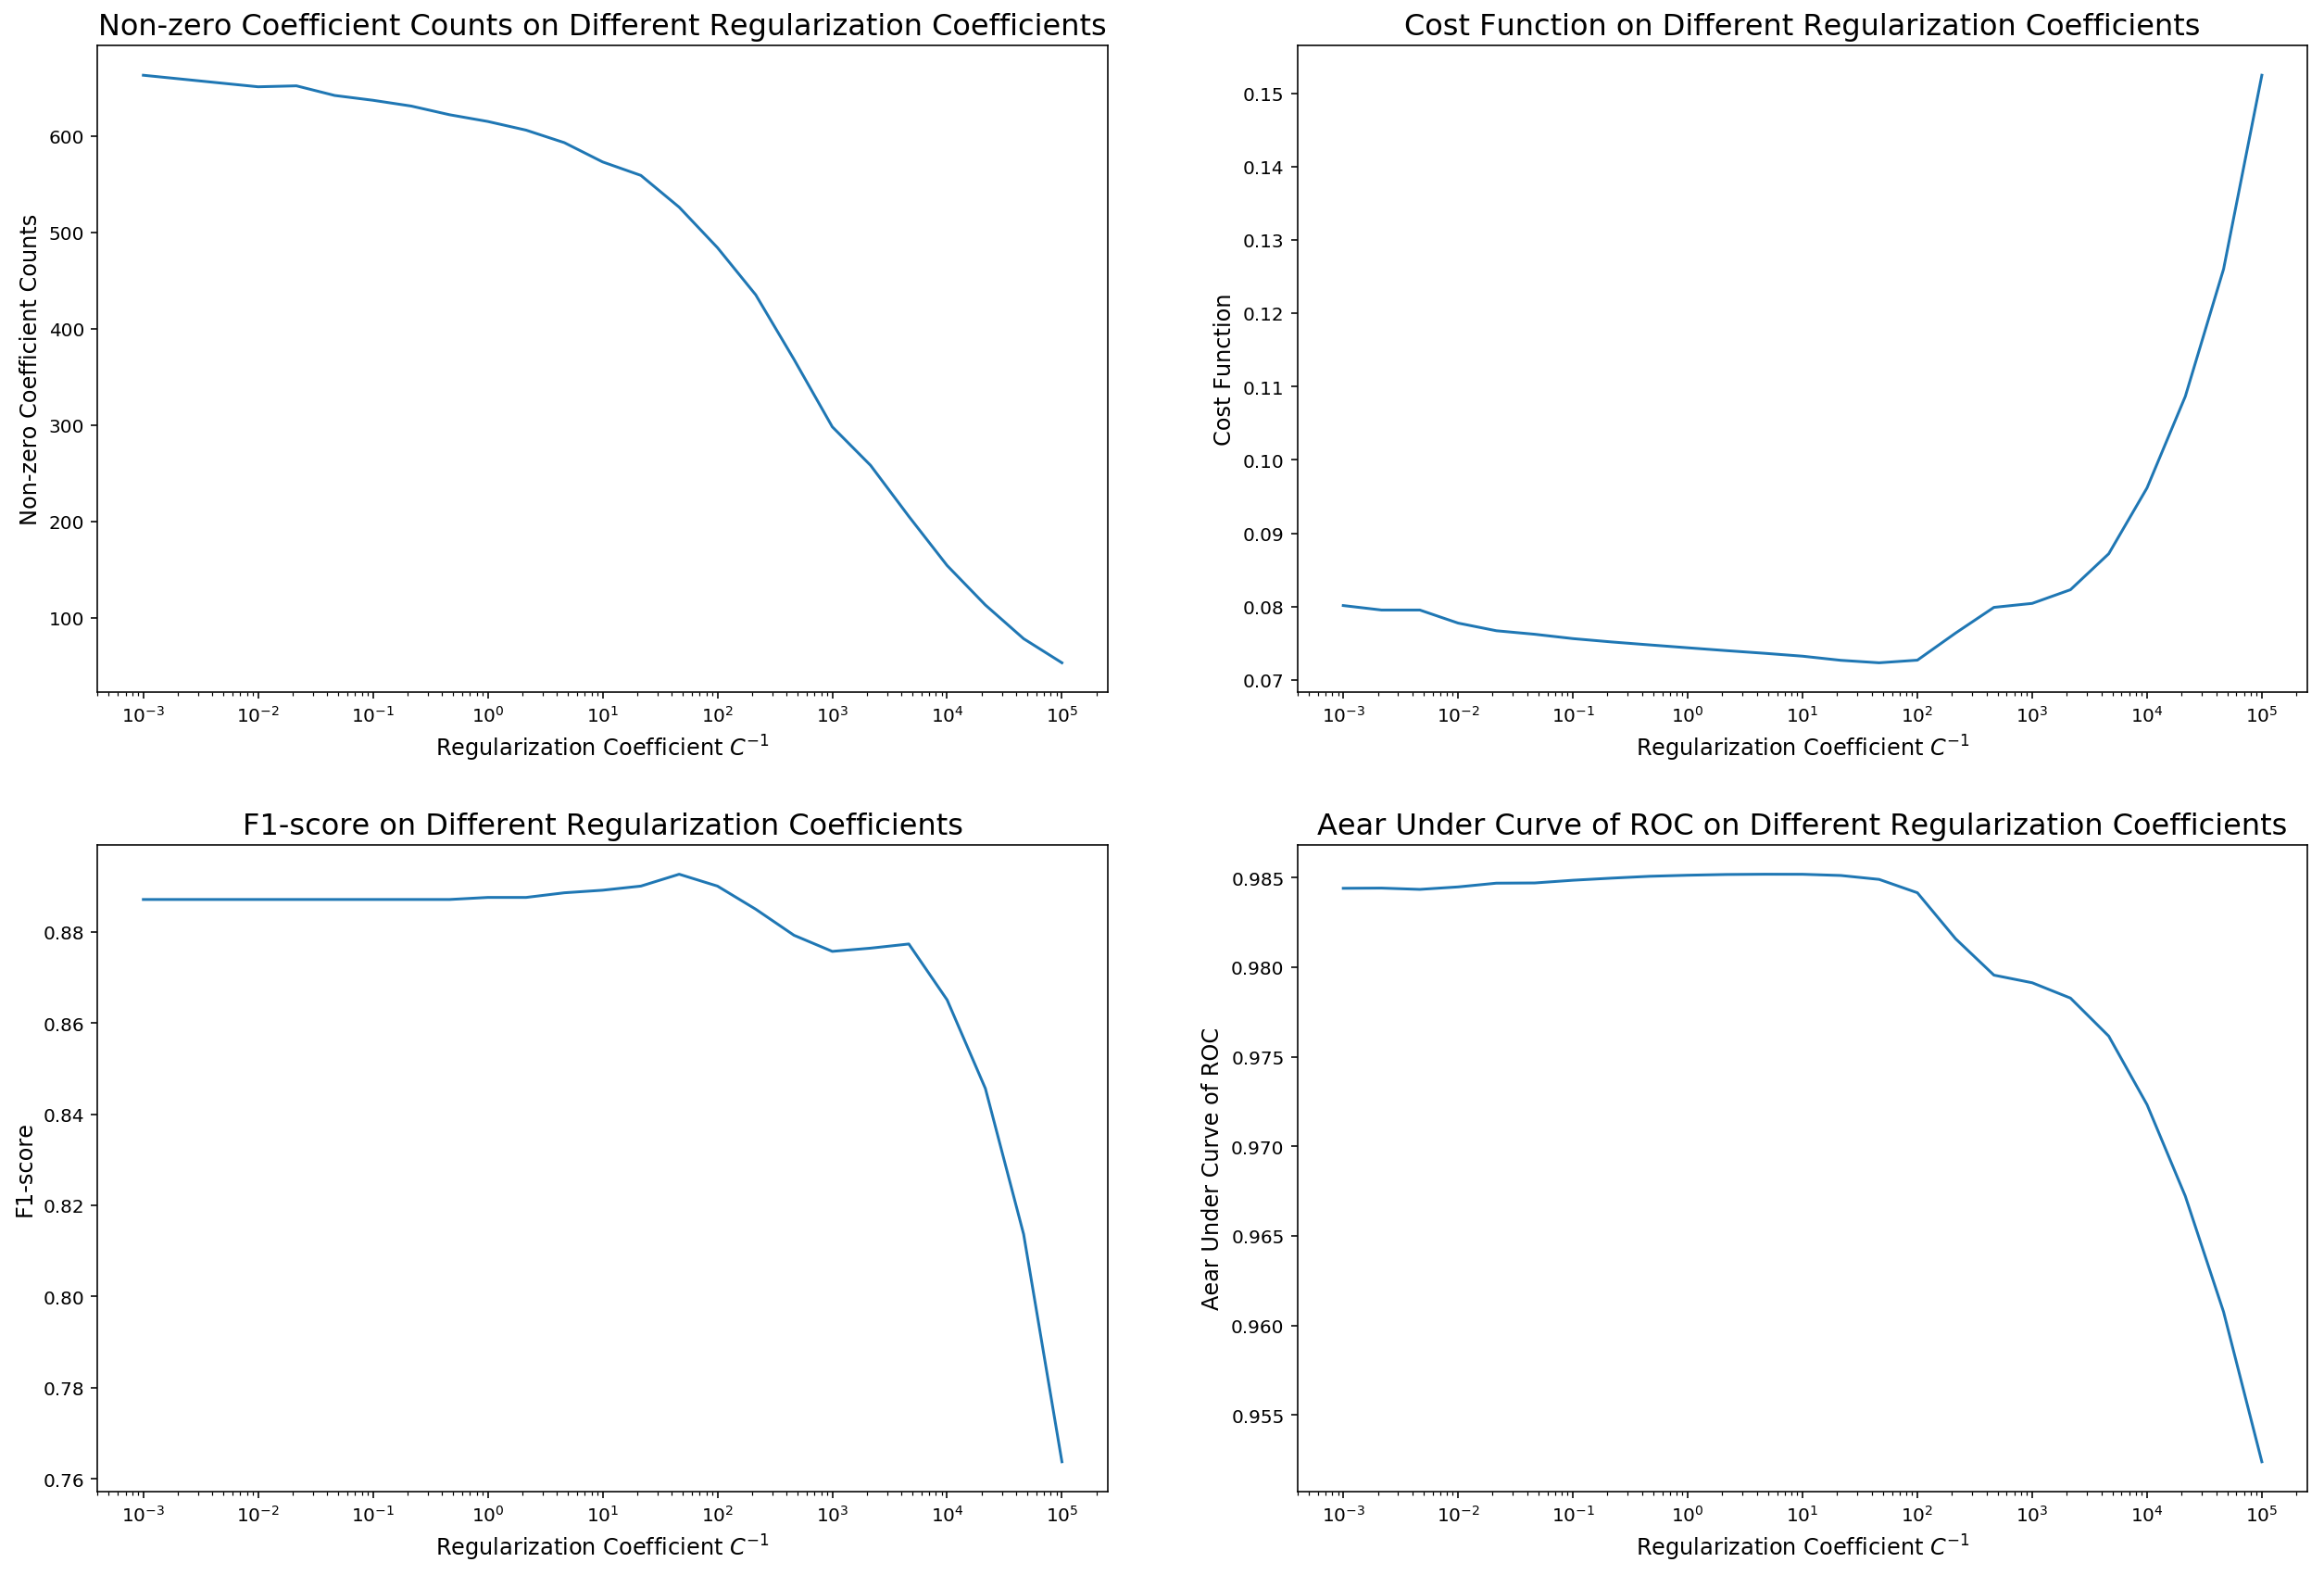

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(18,12))
axsf = axs.flatten()
names = ["Non-zero Coefficient Counts", "Cost Function", "F1-score", "Aear Under Curve of ROC"]
i = 0
for s, name in zip(result_stats, names):
    axsf[i].plot(C**(-1), s, '-')
    axsf[i].set_xscale('log')
    axsf[i].set_title(name+" on Different Regularization Coefficients", fontsize=16)
    axsf[i].set_xlabel("Regularization Coefficient $C^{-1}$", fontsize=12)
    axsf[i].set_ylabel(name, fontsize=12)
    i += 1
plt.tight_layout(h_pad=2)
plt.show()

When the regularization coefficients goes larger, the number of non-zero parameters decreases, which means an increasing strength of dimension reduction. However, the model performance based on cost funciton value, f1-socre and AUC are not always increasing. With increasing regularization strength, the value of cost function first goes down and than goes up dramatically after some specific turning point ($\lambda_0 = C_0^{-1} \approx 5e^{-2}$). Both the f1-score and AUC of ROC first goes up a little bit and then goes down dramatically around the same turning point $\lambda_0$. 

This situations mean that an appropriate value of regularization strength could improve the performance of model (logistics regression) by reducing dimension of parameters. However, when exceeding some turning point, extreme regularization could harm the prediction becuause it shrinkage some parameters of useful features to zero. 

## 3

### [40 points] Supervised learning exploration

For this exercise, you will construct and implement a supervised learning problem solution/experiment. Describe your process and answer these questions clearly and thoroughly. Part of the grade in this assignment is devoted to the quality and professionalism of your work.

**(a)** Identify a question or problem that's of interest to you and that could be addressed using classification or regression. Explain why it's interesting and what you'd like to accomplish. This should exhibit creativity, and you are not allowed to use the Iris dataset, the Kaggle Titanic dataset, or the Kaggle chocolate dataset.

**(b)** Download the data and plot the data to describe it.

**(c)** Formulate your supervised learning question: (a) What is your target variable (what are you trying to predict) and what predictors do you have available? 
v Does your dataset require any preprocessing: is it clean (no missing values or erroneous data) and normalized (are each of the predictors of the same magnitude)? 

**(d)** What supervised learning technique will you use and why? 

**(e)** How will you evaluate performance and know whether you succeeded (e.g. ROC curves for binary classification, mean square error or $R^2$ for regression)?

**(f)** Divide your dataset into training and testing datasets OR implement cross validation. Explain your approach and why you adopted it.

**(g)** Run your analysis and show your performance. Include plots of your data and of performance.

**(h)** Describe how your system performed, where your supervised learning algorithm performed well, and where it did not, and how you could improve it.

**(i)** Write a brief summary / elevator pitch for this work that you would put on LinkedIn to describe this project to future employers. This should focus on the high level impact and importance and overall takeaways and not on the nitty-gritty details.

**ANSWER**

**(a)**

I am interested in computer vision so I choose to do something about image classification. Given images and label, we can teach computer to read images and learn the objects inside images. We could apply this technique to different places like facial recognition, analyzing satellite images, sensor images, etc. 

**(b)**

I choose CIFAR-10 dataset (http://www.cs.utoronto.ca/~kriz/cifar.html), which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 



In [30]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def unpickle_all(dirc, train=True):
    d = b'data'
    l = b'labels'
    if train == True:
        b1 = unpickle(dirc+"data_batch_1")
        b2 = unpickle(dirc+"data_batch_2")
        b3 = unpickle(dirc+"data_batch_3")
        b4 = unpickle(dirc+"data_batch_4")
        b5 = unpickle(dirc+"data_batch_5")
        imgs = np.r_[b1[d], b2[d], b3[d], b4[d], b5[d]]
        labels = b1[l] + b2[l] + b3[l] + b4[l] + b5[l]
    elif train == False:
        bt = unpickle(dirc+"test_batch")
        imgs = np.array(bt[d])
        labels = bt[l]
    return imgs, np.array(labels)

In [31]:
DIR = "./data/A3_cifar-10-batches-py/"
train_images, train_labels = unpickle_all(DIR)
test_images, test_labels = unpickle_all(DIR, train=False)

In [32]:
def make_img(img):
    return img.flatten().reshape(3,32,32).transpose((1,2,0))

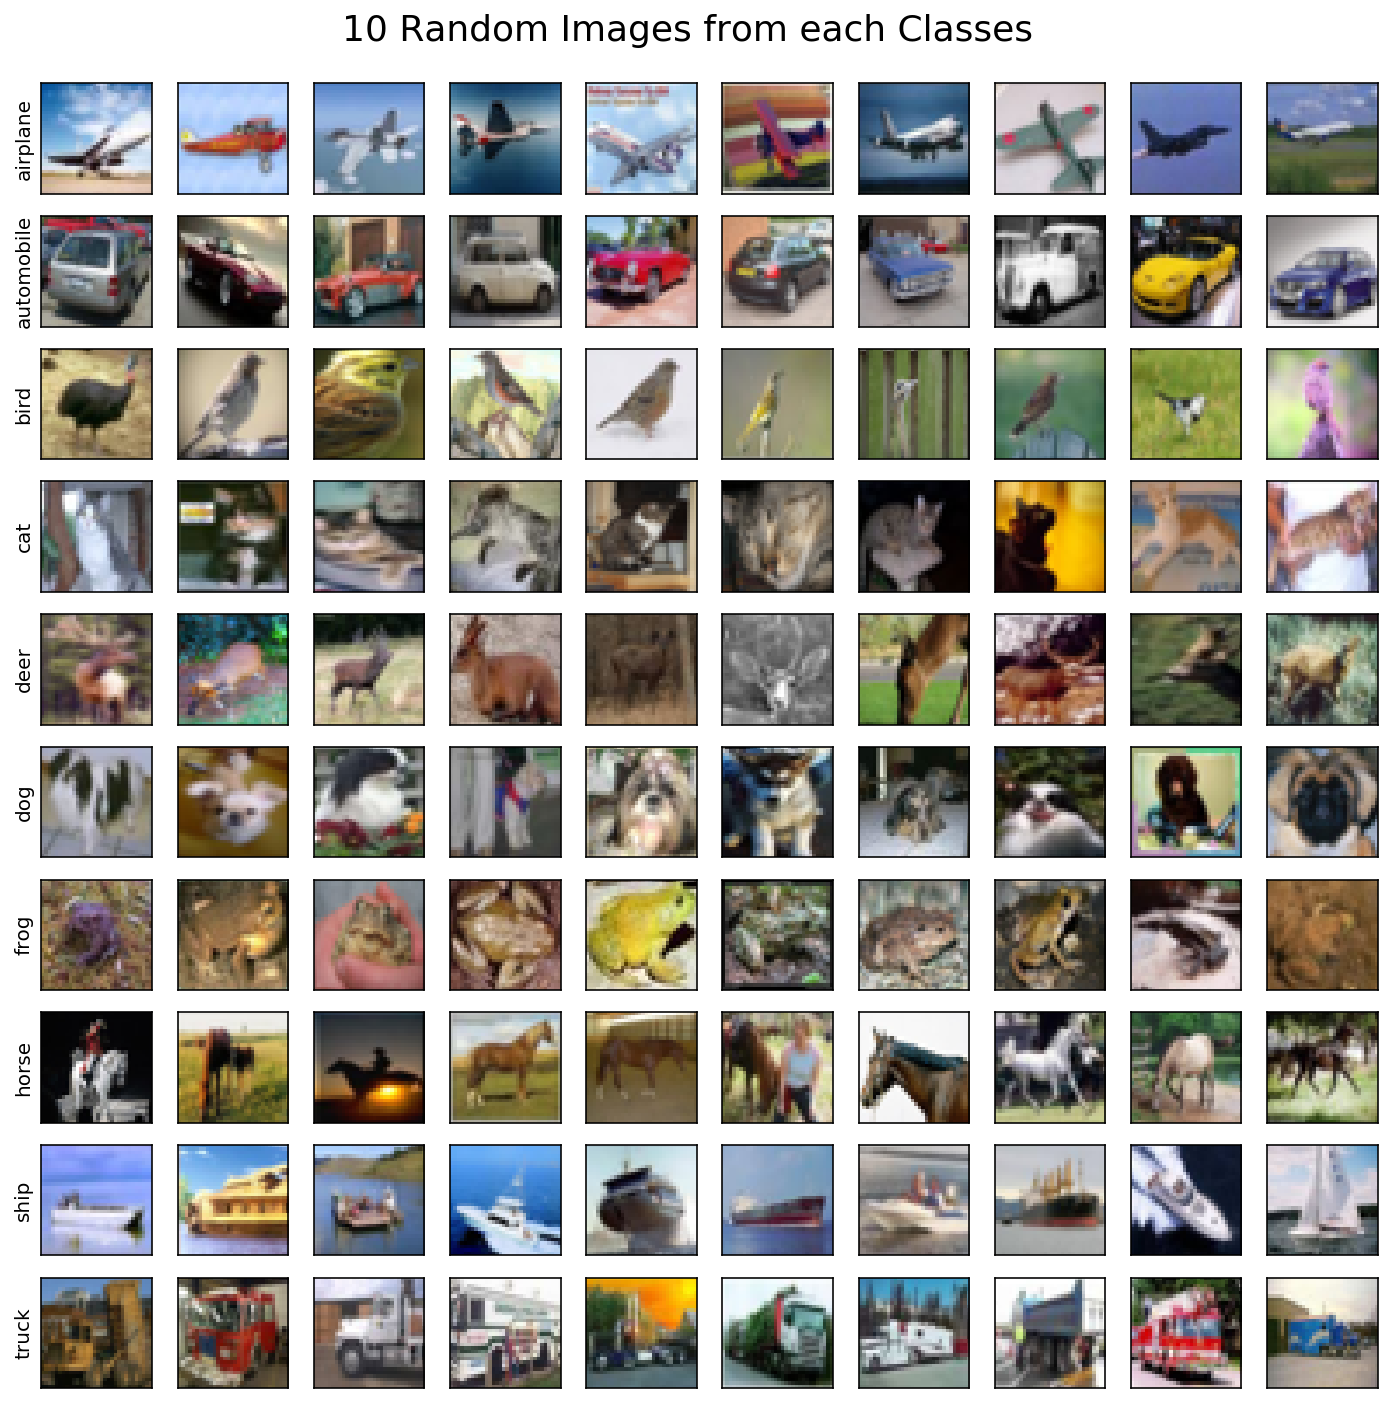

In [33]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axs = plt.subplots(10, 10, figsize=(12,12))
plt.yticks(np.arange(10), label_names)
for l, axr in enumerate(axs):
    axr[0].set_ylabel(label_names[l])
    for ax in axr:
        r = np.random.randint(0,50000)
        while train_labels[r] != l:
            r = np.random.randint(0,50000)
        ax.imshow(make_img(train_images[r]))
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle("10 Random Images from each Classes", y=0.92, fontsize=18)
plt.show()

**(c)**

(a). My target variable is the label of each images and the total 3072 pixels, $32\times32$ images with 3 channels (RGB), are my predictors.

(b). This dataset is well pre-proccessed. It's clean and balanced. Each class has exactly 5000 images. All images have been cropped into $32\times32$ resolution.

To simplify the problem, and also to compromise on my computation resources, I will pick only 2 classes to do a binary classification. Here I picked automobile and ship as the 2 predicted classes.

In [34]:
# Only use airplane and truck for binary classification
a = 1   # automobile
b = 8   # ship
train_index_b_ = np.where((train_labels == a)|(train_labels == b))
test_index_b_ = np.where((test_labels == a)|(test_labels == b))
train_images_b = train_images[train_index_b_]
train_labels_b = train_labels[train_index_b_]
test_images_b = test_images[test_index_b_]
test_labels_b = test_labels[test_index_b_]

**(d)** What supervised learning technique will you use and why?

Since I have 3072 predictors, I will seek ways to reduce the dimensions. I will first use PCA to reduce dimensions and then use the result to fit logistic regression models. Also, PCA could potentially an unsupervised way to recognize patterns, which might be useful in this problem.

Besides logistic regression, I will also try using random forest and boosting method to deal with the high dimensionality in image problems.

**(e)**  How will you evaluate performance and know whether you succeeded (e.g. ROC curves for binary classification, mean square error or  𝑅2  for regression)?

Since this dataset is well-balanced, accuracy will be a good statistics for evaluating the performance. Moreover, I will use AUC of ROC and ROC curve to evaluate the overall performance of my models.

**(f)** Divide your dataset into training and testing datasets OR implement cross validation. Explain your approach and why you adopted it.

Although the dataset has been already split up into training (50000 imges) and testing (10000 images) when downloading, I decide to still use cross-validation to find the best value of hyperparameters, such as the number of pricipal components of PCA and the number of trees of random forest. This will be computational intensive so I decide to only use 5-fold cross-validation.

**(g)** Run your analysis and show your performance. Include plots of your data and of performance.

In [35]:
for n in np.arange(400,49,-50):
    pca = PCA(n_components=n)
    pca_train = pca.fit_transform(train_images_b)
    lr_ = LogisticRegression(max_iter=500, solver='lbfgs')
    cv_results = cross_validate(lr_, pca_train, train_labels_b, scoring=["accuracy", "roc_auc"], cv=5)
    print("PCA components: ", n)
    print("acc: %.4f\t%a" % (np.mean(cv_results["test_accuracy"]), cv_results["test_accuracy"]))
    print("AUC: %.4f\t%a" % (np.mean(cv_results["test_roc_auc"]), cv_results["test_roc_auc"]))
    print("-"*80)

PCA components:  400
acc: 0.8224	array([0.8205, 0.821 , 0.826 , 0.821 , 0.8235])
AUC: 0.9000	array([0.896276, 0.899768, 0.904734, 0.901026, 0.898185])
--------------------------------------------------------------------------------
PCA components:  350
acc: 0.8228	array([0.813 , 0.825 , 0.8275, 0.8245, 0.824 ])
AUC: 0.9008	array([0.896079, 0.901077, 0.906333, 0.901778, 0.898586])
--------------------------------------------------------------------------------
PCA components:  300
acc: 0.8231	array([0.813 , 0.8265, 0.8295, 0.818 , 0.8285])
AUC: 0.9017	array([0.894951, 0.902998, 0.908541, 0.902898, 0.899076])
--------------------------------------------------------------------------------
PCA components:  250
acc: 0.8249	array([0.822 , 0.8235, 0.8275, 0.8225, 0.829 ])
AUC: 0.9029	array([0.898123, 0.902424, 0.908749, 0.903699, 0.901726])
--------------------------------------------------------------------------------
PCA components:  200
acc: 0.8245	array([0.825 , 0.8265, 0.8255, 0.8205, 

In [36]:
for n in np.arange(200, 501, 100):
    rf_ = RandomForestClassifier(n_estimators=n)
    cv_results = cross_validate(rf_, train_images_b, train_labels_b, scoring=["accuracy", "roc_auc"], cv=5)
    print("Tree count: ", n)
    print("acc: %.4f\t%a" % (np.mean(cv_results["test_accuracy"]), cv_results["test_accuracy"]))
    print("AUC: %.4f\t%a" % (np.mean(cv_results["test_roc_auc"]), cv_results["test_roc_auc"]))
    print("-"*80)

Tree count:  200
acc: 0.8497	array([0.8475, 0.86  , 0.8605, 0.842 , 0.8385])
AUC: 0.9211	array([0.919742 , 0.922072 , 0.9304075, 0.9163765, 0.916689 ])
--------------------------------------------------------------------------------
Tree count:  300
acc: 0.8532	array([0.853 , 0.8645, 0.8615, 0.844 , 0.843 ])
AUC: 0.9215	array([0.9214205, 0.9221175, 0.927869 , 0.917234 , 0.918718 ])
--------------------------------------------------------------------------------
Tree count:  400
acc: 0.8536	array([0.857 , 0.86  , 0.861 , 0.8445, 0.8455])
AUC: 0.9217	array([0.9214805, 0.9237605, 0.9292625, 0.9167895, 0.917206 ])
--------------------------------------------------------------------------------
Tree count:  500
acc: 0.8534	array([0.853 , 0.86  , 0.861 , 0.8425, 0.8505])
AUC: 0.9221	array([0.9220125, 0.923874 , 0.929031 , 0.9170575, 0.9186165])
--------------------------------------------------------------------------------


In [37]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    logit_ = LogisticRegression(max_iter=500, solver='lbfgs').fit(train_images_b, train_labels_b)

In [38]:
# Logistic Regression
pca = PCA(n_components=200)
pca_train = pca.fit_transform(train_images_b)
pca_test = pca.transform(test_images_b)
logit = LogisticRegression(max_iter=500, solver='lbfgs').fit(pca_train, train_labels_b)

In [39]:
# Random Forest
rf = RandomForestClassifier(n_estimators=500).fit(train_images_b, train_labels_b)

In [40]:
# xgboost
xgb = GradientBoostingClassifier().fit(train_images_b, train_labels_b)

*** Logistic Regression***
Mean ACC: 76.00%
AUC of ROC: 0.8411
              precision    recall  f1-score   support

           1       0.78      0.72      0.75      1000
           8       0.74      0.80      0.77      1000

   micro avg       0.76      0.76      0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



*** Logistic Regression with PCA ***
Mean ACC: 82.20%
AUC of ROC: 0.8919
              precision    recall  f1-score   support

           1       0.82      0.82      0.82      1000
           8       0.82      0.82      0.82      1000

   micro avg       0.82      0.82      0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



*** Random Forest ***
Mean ACC: 85.00%
AUC of ROC: 0.9165
              precision    recall  f1-score   support

           1       0.82      0.89      0.86      1000
           8       0.88      0.81      

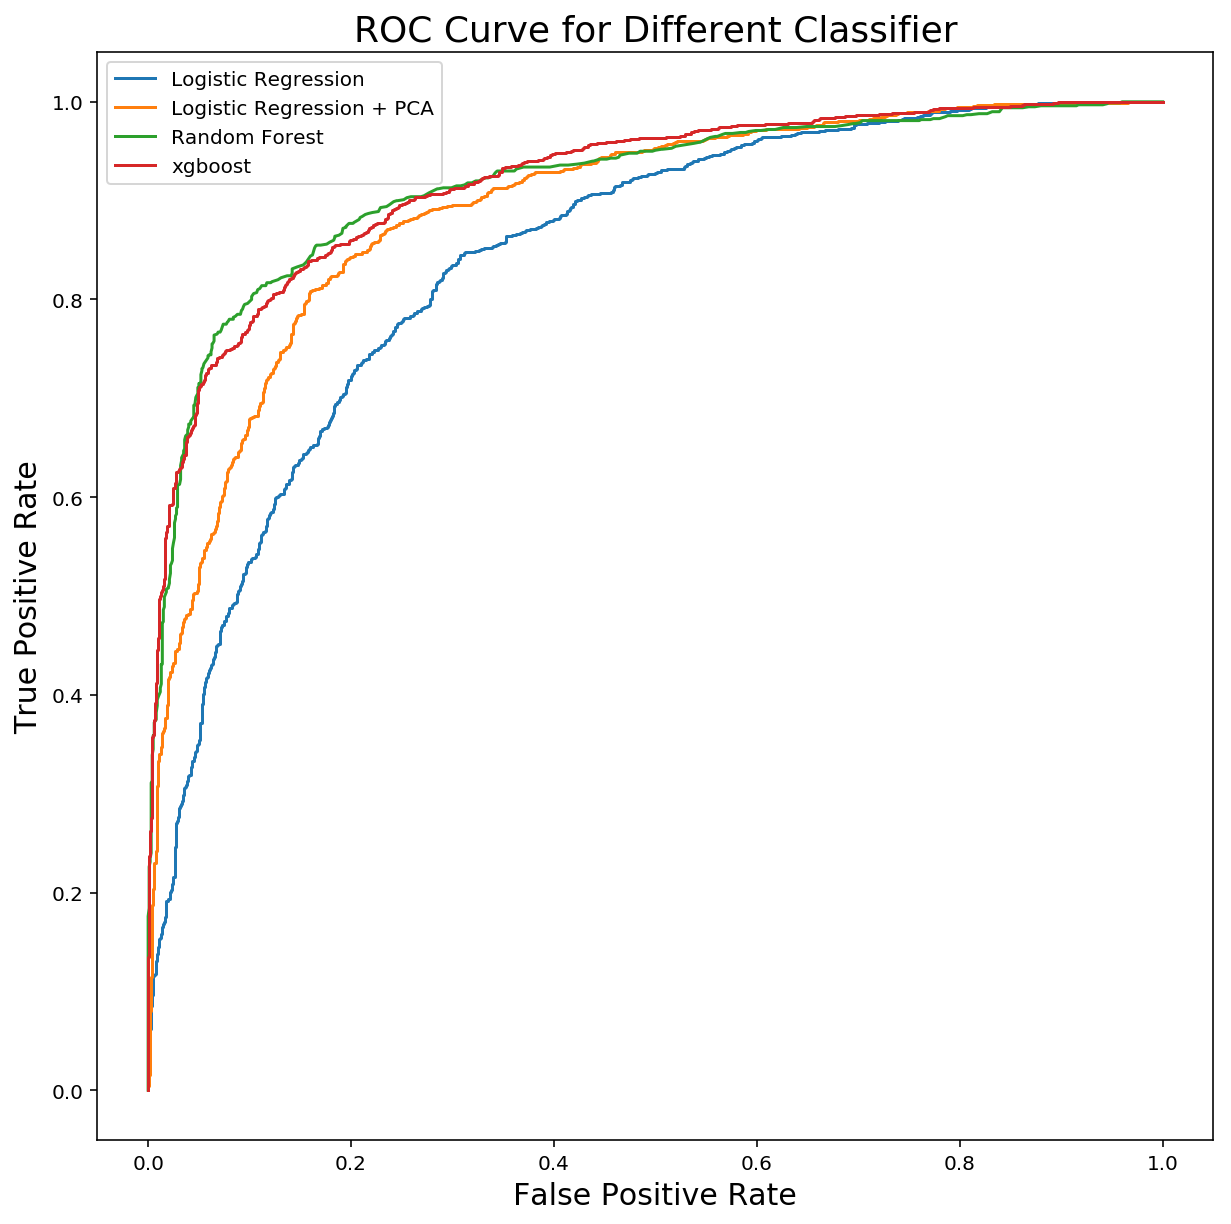

In [41]:
plt.figure(figsize=(10,10))

print("*** Logistic Regression***")
logit_prob = logit_.predict_proba(test_images_b)[:,1]
fpr, tpr, thr = roc_curve(test_labels_b, logit_prob, pos_label=b)
plt.plot(fpr, tpr, label="Logistic Regression")
print("Mean ACC: %.2f%%" % (100*logit_.score(test_images_b, test_labels_b)))
print("AUC of ROC: %.4f" % roc_auc_score(test_labels_b, logit_prob))
print(classification_report(test_labels_b, logit_.predict(test_images_b)))
print("\n"+"="*60+"\n")

print("*** Logistic Regression with PCA ***")
lr_prob = logit.predict_proba(pca_test)[:,1]
fpr, tpr, thr = roc_curve(test_labels_b, lr_prob, pos_label=b)
plt.plot(fpr, tpr, label="Logistic Regression + PCA")
print("Mean ACC: %.2f%%" % (100*logit.score(pca_test, test_labels_b)))
print("AUC of ROC: %.4f" % roc_auc_score(test_labels_b, lr_prob))
print(classification_report(test_labels_b, logit.predict(pca_test)))
print("\n"+"="*60+"\n")

print("*** Random Forest ***")
rf_prob = rf.predict_proba(test_images_b)[:,1]
fpr, tpr, thr = roc_curve(test_labels_b, rf_prob, pos_label=b)
plt.plot(fpr, tpr, label="Random Forest")
print("Mean ACC: %.2f%%" % (100*rf.score(test_images_b, test_labels_b)))
print("AUC of ROC: %.4f" % roc_auc_score(test_labels_b, rf_prob))
print(classification_report(test_labels_b, rf.predict(test_images_b)))
print("\n"+"="*60+"\n")

print("*** xgboost ***")
xgb_prob = xgb.predict_proba(test_images_b)[:,1]
fpr, tpr, thr = roc_curve(test_labels_b, xgb_prob, pos_label=b)
plt.plot(fpr, tpr, label="xgboost")
print("Mean ACC: %.2f%%" % (100*xgb.score(test_images_b, test_labels_b)))
print("AUC of ROC: %.4f" % roc_auc_score(test_labels_b, xgb_prob))
print(classification_report(test_labels_b, xgb.predict(test_images_b)))
print("\n"+"="*60+"\n")

plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve for Different Classifier", fontsize=18)
plt.legend()
plt.show()

In [42]:
### Try to use 3 classes to do multi-class classification
a = 1   # automobile
b = 8   # ship
c = 0   # airplane
train_index_t_ = np.where((train_labels == a)|(train_labels == b)|(train_labels == c))
test_index_t_ = np.where((test_labels == a)|(test_labels == b)|(test_labels == c))
train_images_t = train_images[train_index_t_]
train_labels_t = train_labels[train_index_t_]
test_images_t = test_images[test_index_t_]
test_labels_t = test_labels[test_index_t_]

In [43]:
pca_t = PCA(n_components=400)
pca_train_t = pca_t.fit_transform(train_images_t)
pca_test_t = pca_t.transform(test_images_t)
lr_t = LogisticRegression(multi_class='auto', max_iter=1000, solver='lbfgs').fit(pca_train_t, train_labels_t)

In [44]:
rf_t = RandomForestClassifier(n_estimators=500).fit(train_images_t, train_labels_t)

In [45]:
print("***** Random Forest *****")
rf_t_pre = rf_t.predict(test_images_t)
print("Mean ACC: %.2f%%" % (100*rf_t.score(test_images_t, test_labels_t)))
print(classification_report(test_labels_t, rf_t_pre))

print("***** Logistic Regression with PCA *****")
lr_t_pre = lr_t.predict(pca_test_t)
print("Mean ACC: %.2f%%" % (100*lr_t.score(pca_test_t, test_labels_t)))
print(classification_report(test_labels_t, lr_t_pre))

***** Random Forest *****
Mean ACC: 74.67%
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1000
           1       0.74      0.84      0.79      1000
           8       0.71      0.70      0.71      1000

   micro avg       0.75      0.75      0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000

***** Logistic Regression with PCA *****
Mean ACC: 66.87%
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1000
           1       0.74      0.73      0.73      1000
           8       0.63      0.63      0.63      1000

   micro avg       0.67      0.67      0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000



**(h)** Describe how your system performed, where your supervised learning algorithm performed well, and where it did not, and how you could improve it.

My models perform not that well on this dataset, comparing to the MNIST dataset. Among these four models I used, random forest has the best performances and stability, while logistic regression has the worst performance. However, PCA could help improve logistic regression a lot (mean acc improved from 0.76 to 0.82). Also, the number of pricipal components is crucial but not that sensitive to changes. As for ensemble methods, since my dataset is relatively large, I don't need to worry too much about a big number of trees or big number of estimators for boosting. However, I didn't try a large number for this because it might take a long time to do so, especially when I also have a cross-validation to run with. Last but not least, the performance for all these four models are balanced, with no too large or too small precision or recall.

However, in general, my model perform not that well on this dataset. One possible reason is that the images is colorful, containing more complex information, which might be hard for these models to capture. The other possible reason is these are real images, which has too much noises (e.g. ship and airplane have similar shape with blue background). Even in the same class the objects are total different, while these models has a relatively small feature numbers compared to CNN, making these classfication method perform not that well.

Also, I also picked logistic regression with PCA and random forest to run a 3 classes classification test. We can see that in this situation, random forest perform much better than logistic regression. It has a higher mean accuracy, precision and recall, according to the table above.

**(i)** Write a brief summary / elevator pitch for this work that you would put on LinkedIn to describe this project to future employers. This should focus on the high level impact and importance and overall takeaways and not on the nitty-gritty details.

Images classification is a big part of computer vision. With this techinque, we could let computer do so many important things such as facial recognition, statellite images analysis, etc. I implement logistic regression, PCA + logistic regression, random forest and boosting method to classify different images from CIFAR-10 dataset. I choose 2 classes to start with and later try models on 3 classes. Although the overall performances are not that well as compared to CNN, they are easy-to-train and not that computationally intensive as CNN. This gives us an easy way to update our model whenever new imgaes come in. Moreover, PCA could imporve the performance of logistic a lot, since we have a large feature space with some redundant information. Among all these 4 models, random forest has the best performance and stability (mean acc 0.85 for 2 classes). It also perform well on 3 classes classification (mean acc 0.75), even when 2 of the classes are visually similar (airplane and ship).